# Info
Name:  

    COSR_DARE

Purpose:  

    To Build the COSR DARE calculations
  
Input:

    arguments
  
Output:

    Figure and save files
  
Keywords:

    none
  
Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - ...
  
Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2019-10-04
    Modified: 

# Prepare python environment

In [ ]:
import numpy as np
import Sp_parameters as Sp
import load_utils as lu
from path_utils import getpath
import hdf5storage as hs
import scipy.io as sio
from datetime import datetime
from scipy.interpolate import UnivariateSpline, interp1d
from scipy import interpolate 
import pandas as pd
import matplotlib.pyplot as plt
import Sun_utils as su

In [ ]:
%matplotlib notebook

In [ ]:
import Run_libradtran as RL
import os
import write_utils as wu
from tqdm.notebook import tqdm

In [ ]:
name = 'COSR'
vv = 'v3b'

In [ ]:
fp =getpath('COSR')

In [6]:
day = '20180609'
day = '20180618'
#day = '20180624'
#day = '20180625'


In [149]:
#get the paths
fp_rtm = getpath('rtm')
fpp_in = fp_rtm+'input/{}_{}_CRE_{}/'.format(name,day,vv)
fpp_out = fp_rtm+'output/{}_{}_CRE_{}/'.format(name,day,vv)
fp_uv = getpath('uvspecb')+'uvspec'
fp_librad = getpath('libradtranb')+'data/'

Return path named:  rtm /scratch/rtm/
Return path named:  uvspecb /home/sam/libradtran/libRadtran-2.0.2b/bin/
Return path named:  libradtranb /home/sam/libradtran/libRadtran-2.0.2b/


# Load files

## Load the 4STAR AOD

In [8]:
s = sio.loadmat(fp+'os_data/4STAR_{}starsun.mat'.format(day))

In [9]:
s.keys()

['El_gnd',
 'Str',
 'tau_O3_err',
 'sza',
 'nirfilen',
 'toggle',
 'pitch',
 'Tst',
 'cwv',
 'fwhm',
 'ground',
 'flagsO3',
 'nirt',
 'tau_aero_noscreening',
 'rateaero',
 'O3h',
 'NO2col',
 'Headng',
 'RH',
 'Pst',
 'tau_aero_subtract_all',
 'nirheader',
 'nirdatatype',
 'sd_aero_crit',
 'tau_aero_err',
 'dark',
 'nirVdettemp',
 'Elstep',
 'tau_ray',
 'nircols',
 'sunaz',
 'O3col',
 'm_ray',
 'm_err',
 'forj_corr',
 'tau_O4_err',
 'flagsNO2',
 't',
 'c0mod',
 'tau_tot_slant',
 'track_err',
 'rate',
 'daystr',
 'program_version',
 'sat_time',
 'm_O3',
 'tau_aero_err2',
 'visheader',
 'Az_deg',
 'nirTint',
 'filename',
 'tau_r_err',
 'nirsat_pixel',
 'Md',
 'aeronetcols',
 'rateslant',
 'visAVG',
 'tau_NO2_err',
 'Zn',
 'AZstep',
 'darkstd',
 'visdatatype',
 'QdVtot',
 'tau_aero_err7',
 'tau_aero_err6',
 'tau_aero_err5',
 'nirAVG',
 'tau_tot_vert',
 'sun_sky_Az_offset',
 'w',
 'ELcorr',
 'visVdettemp_C',
 'tau_aero_err8',
 'El_deg',
 'skyresp',
 'Lon',
 'tau_aero',
 'AZ_deg',
 'visrow_l

In [10]:
s['utc'] = lu.toutc(lu.mat2py_time(s['t']))

### Load the flag files

In [20]:
fmat = getpath('4STAR_data')

Return path named:  4STAR_data /home/sam/4STAR_codes/data_folder/


In [21]:
with open (fmat+'starinfo_{}.m'.format(day), 'rt') as in_file:
    for line in in_file:
        if 'flagfilename ' in line:
            ff = line.split("'")[1]
sf = hs.loadmat(fmat+ff)

In [22]:
sf.keys()

[u'unspecified_clouds',
 u'manual_flags',
 u'bad_aod',
 u'flagfile',
 u'screen',
 u'frost',
 u'before_or_after_flight',
 u'unspecified_aerosol',
 u'hor_legs',
 u'flags',
 u'low_cloud',
 u'smoke',
 u'time',
 u'dust',
 u'vert_legs',
 u'screened',
 u'cirrus']

In [23]:
flag = sf['manual_flags']['good'][0,:,0]

In [24]:
flag.shape

(19716,)

In [25]:
sum(flag)

6582

### use the polyfit aod on the wavelength array

In [11]:
s['tau_aero_polynomial'].shape

(19716, 3)

In [12]:
wvl = np.array([0.25,0.35,0.4,0.5,0.675,0.87,0.995,1.2,1.4,1.6,2.1,3.2,4.9])

In [13]:
s['aod'] = np.zeros((len(s['utc']),len(wvl)))
for i in xrange(len(s['utc'])):
    s['aod'][i,:] = np.exp(np.polyval([s['tau_aero_polynomial'][i,0],s['tau_aero_polynomial'][i,1],
                                       s['tau_aero_polynomial'][i,2]],
                                         np.log(wvl)))


In [23]:
s['aod'].shape

(17730, 13)

In [24]:
s['aod'][10:-1:200,:].shape

(89, 13)

<IPython.core.display.Javascript object>


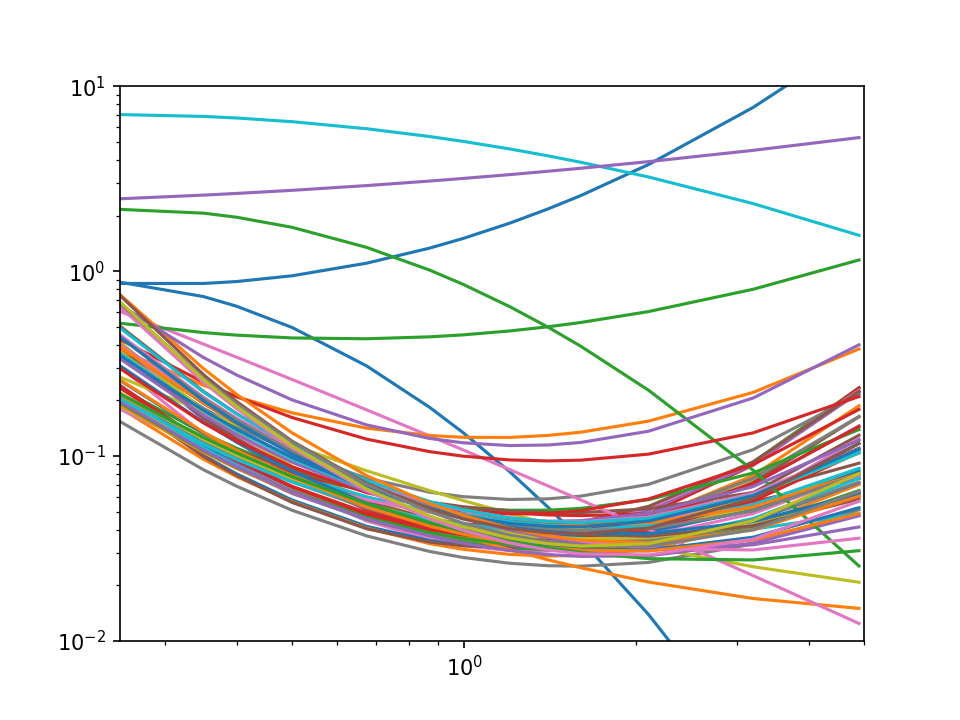

(0.25, 5)

In [25]:
plt.figure()
plt.plot(wvl,s['aod'][10:-1:200,:].T)
plt.ylim(0,1)
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.01,10)
plt.xlim(0.25,5)

### Alternative build of tau aero polynomials for AOD

In [14]:
wvl = np.array([0.25,0.35,0.4,0.5,0.675,0.87,0.995,1.2,1.4,1.6,2.1,3.2,4.9])

In [15]:
sai = s['aerosolcols'][0,:].astype(int)

<IPython.core.display.Javascript object>


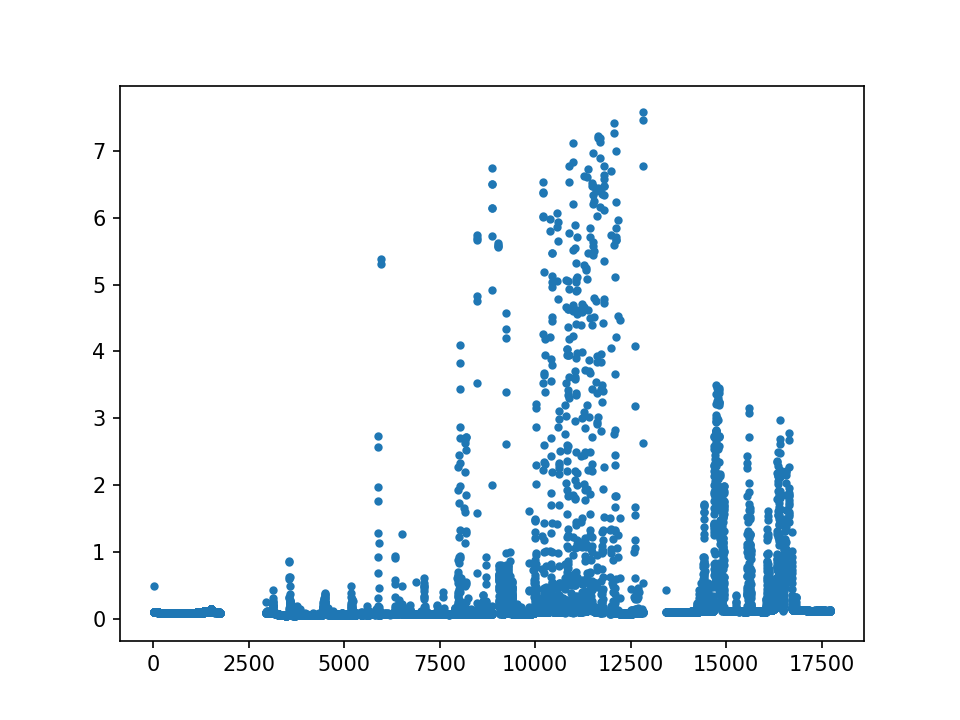

In [28]:
plt.figure()
plt.plot(s['tau_aero'][:,400],'.')

In [16]:
i=13884

In [17]:
s['tau_aero'].shape

(19716, 1556)

In [18]:
s['w'].shape

(1, 1556)

<IPython.core.display.Javascript object>


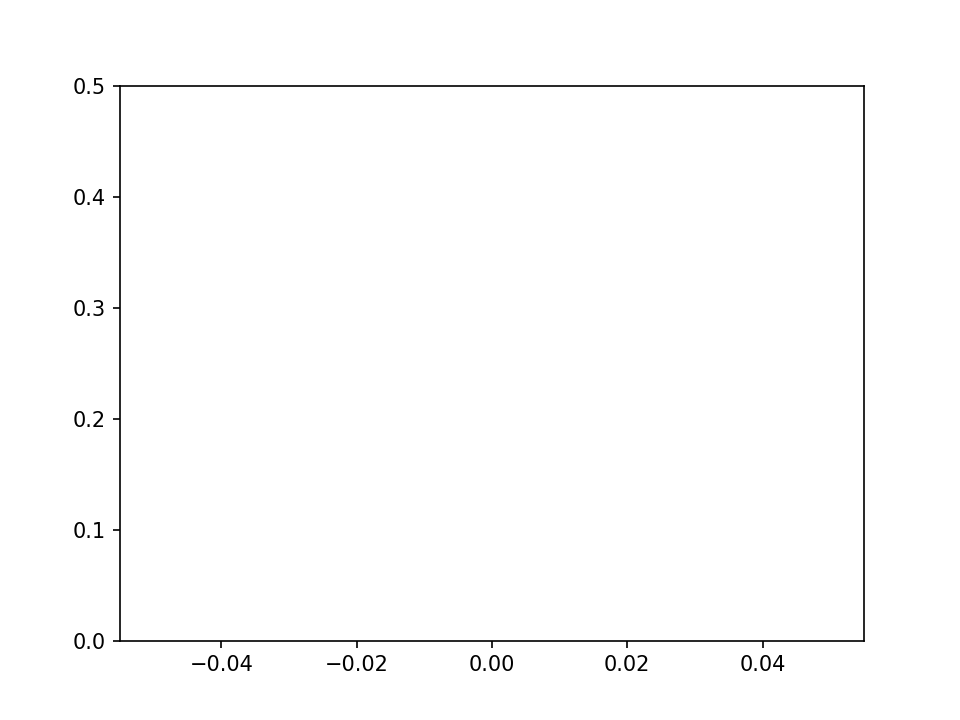

(0, 0.5)

In [31]:
plt.figure()
plt.plot(s['w'][0,:],s['tau_aero'][i,:],'-')
plt.plot(s['w'][0,sai],s['tau_aero'][i,sai],'.')
#plt.plot(wvl,s['aod'][i,:],'x-')
plt.ylim(0,0.5)


In [26]:
np.where(flag)[0]

array([    5,     6,     7, ..., 19580, 19581, 19582])

<IPython.core.display.Javascript object>


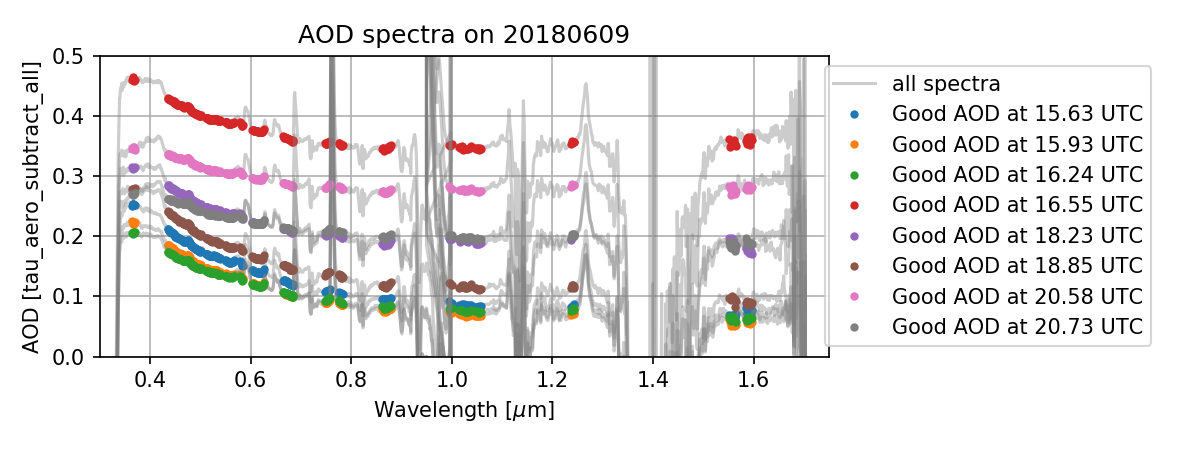

In [788]:
plt.figure(figsize=(8,3))
jfirst=True
for i in np.where(flag)[0]:
    if i%500 ==0:
        if jfirst:
            plt.plot(s['w'][0,:],s['tau_aero_subtract_all'][i,:],'-',color='grey',alpha=0.4,label='all spectra')
            jfirst=False
        else:
            plt.plot(s['w'][0,:],s['tau_aero_subtract_all'][i,:],'-',color='grey',alpha=0.4)
        plt.plot(s['w'][0,saii],s['tau_aero_subtract_all'][i,saii],'.',label='Good AOD at {:2.2f} UTC'.format(s['utc'][i]))
#plt.plot(wvl,s['aod'][i,:],'x-')
plt.ylim(0,0.5)
plt.xlim(0.3,1.75)
plt.grid()
plt.legend(bbox_to_anchor=(0.98, 1), loc='upper left', ncol=1)

plt.xlabel('Wavelength [$\mu$m]')
plt.ylabel('AOD [tau_aero_subtract_all]')
plt.title('AOD spectra on {}'.format(day))
plt.tight_layout()
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.96, box.height])
plt.savefig(fp+'plots/Good_AOD_spectra_examples_{}.png'.format(day),dpi=600,transparent=True)

In [777]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

<IPython.core.display.Javascript object>


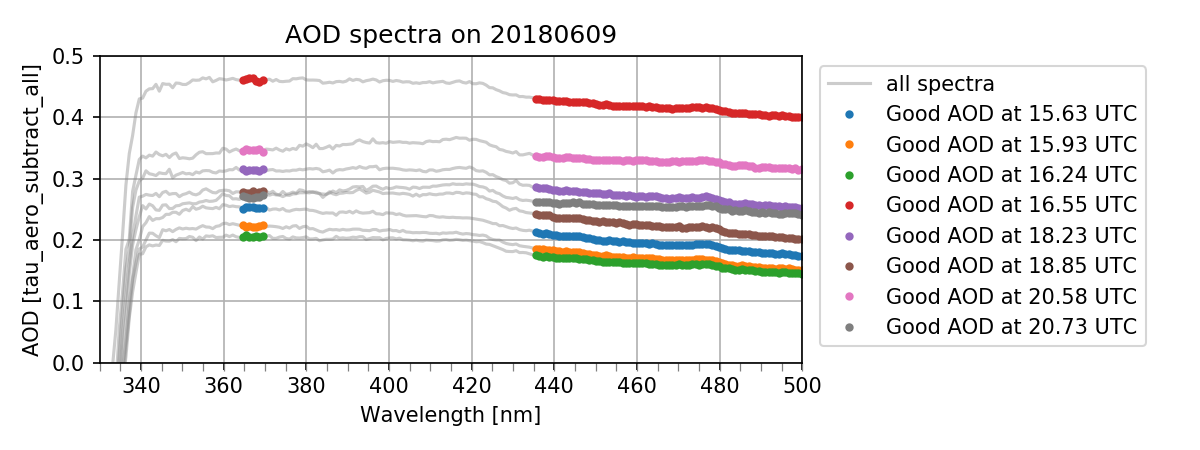

In [787]:
plt.figure(figsize=(8,3))
jfirst=True
for i in np.where(flag)[0]:
    if i%500 ==0:
        if jfirst:
            plt.plot(s['w'][0,:]*1000.0,s['tau_aero_subtract_all'][i,:],'-',color='grey',alpha=0.4,label='all spectra')
            jfirst=False
        else:
            plt.plot(s['w'][0,:]*1000.0,s['tau_aero_subtract_all'][i,:],'-',color='grey',alpha=0.4)
        plt.plot(s['w'][0,saii]*1000.0,s['tau_aero_subtract_all'][i,saii],'.',label='Good AOD at {:2.2f} UTC'.format(s['utc'][i]))
#plt.plot(wvl,s['aod'][i,:],'x-')
plt.ylim(0,0.5)
plt.xlim(330,500)
plt.grid(which='major')

plt.gca().xaxis.set_minor_locator(MultipleLocator(5))
plt.gca().tick_params(which='minor', length=4, color='grey')

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)

plt.xlabel('Wavelength [nm]')
plt.ylabel('AOD [tau_aero_subtract_all]')
plt.title('AOD spectra on {}'.format(day))
plt.tight_layout()
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.96, box.height])
plt.savefig(fp+'plots/Good_AOD_spectra_examples_zoomed_{}.png'.format(day),dpi=600,transparent=True)

In [752]:
s['w'][0,saii]

array([0.364636 , 0.365444 , 0.366251 , 0.367059 , 0.367866 , 0.368674 ,
       0.369481 , 0.435602 , 0.436407 , 0.437212 , 0.438017 , 0.438821 ,
       0.439626 , 0.440431 , 0.441236 , 0.442041 , 0.442845 , 0.44365  ,
       0.444455 , 0.445259 , 0.446064 , 0.446868 , 0.447673 , 0.448477 ,
       0.449282 , 0.450086 , 0.450891 , 0.451695 , 0.452499 , 0.453303 ,
       0.454108 , 0.454912 , 0.455716 , 0.45652  , 0.457324 , 0.458128 ,
       0.458932 , 0.459736 , 0.46054  , 0.461344 , 0.462147 , 0.462951 ,
       0.463755 , 0.464559 , 0.465362 , 0.466166 , 0.466969 , 0.467773 ,
       0.468576 , 0.46938  , 0.470183 , 0.470987 , 0.47179  , 0.472593 ,
       0.473396 , 0.4742   , 0.475003 , 0.475806 , 0.476609 , 0.477412 ,
       0.478215 , 0.479018 , 0.479821 , 0.480624 , 0.481427 , 0.482229 ,
       0.483032 , 0.483835 , 0.484638 , 0.48544  , 0.486243 , 0.487045 ,
       0.487848 , 0.48865  , 0.489453 , 0.490255 , 0.491057 , 0.49186  ,
       0.492662 , 0.493464 , 0.494266 , 0.495068 , 

<IPython.core.display.Javascript object>


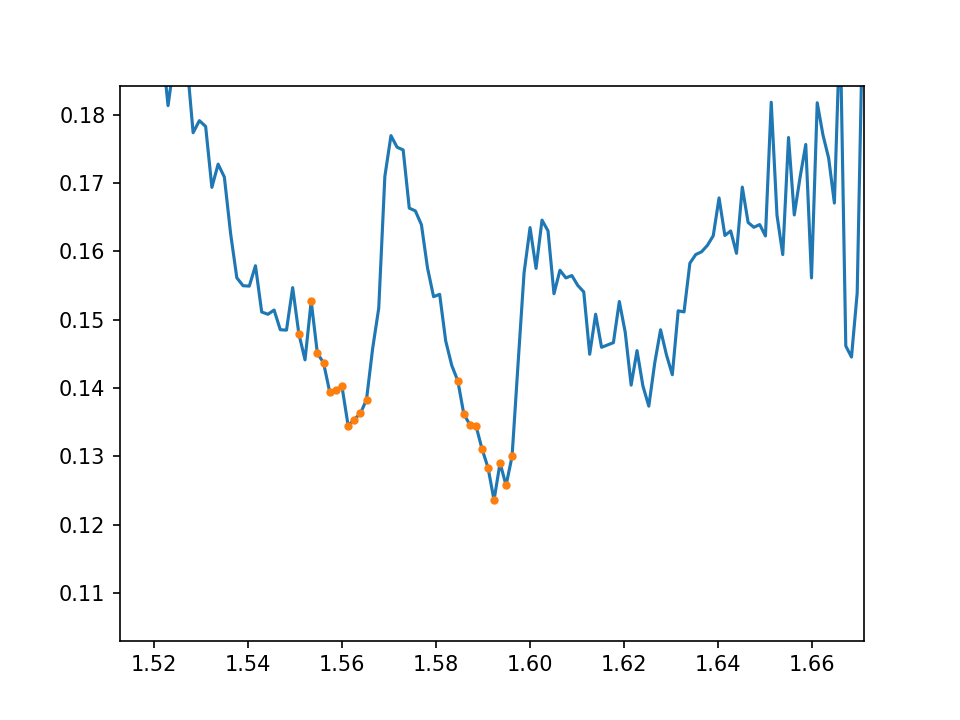

(0, 0.5)

In [583]:
plt.figure()
plt.plot(s['w'][0,:],s['tau_aero'][i,:],'-')
plt.plot(s['w'][0,saii],s['tau_aero'][i,saii],'.')
plt.ylim(0,0.5)

In [27]:
saii = sai[((s['w'][0,sai]>0.364) & (s['w'][0,sai]<0.370)) | ((s['w'][0,sai]>0.435) & (s['w'][0,sai]<1.566)) | 
            ((s['w'][0,sai]>1.584) & (s['w'][0,sai]<1.597)) ]

In [28]:
pl = su.logaod_polyfit(np.append(s['w'][0,saii],[2.2,2.7,3.5]),np.append(s['tau_aero'][i,saii],[s['tau_aero'][i,saii][-1]*2.0/3.0,s['tau_aero'][i,saii][-1]/2.0,s['tau_aero'][i,saii][-1]/4.0]),polynum=2)

<IPython.core.display.Javascript object>


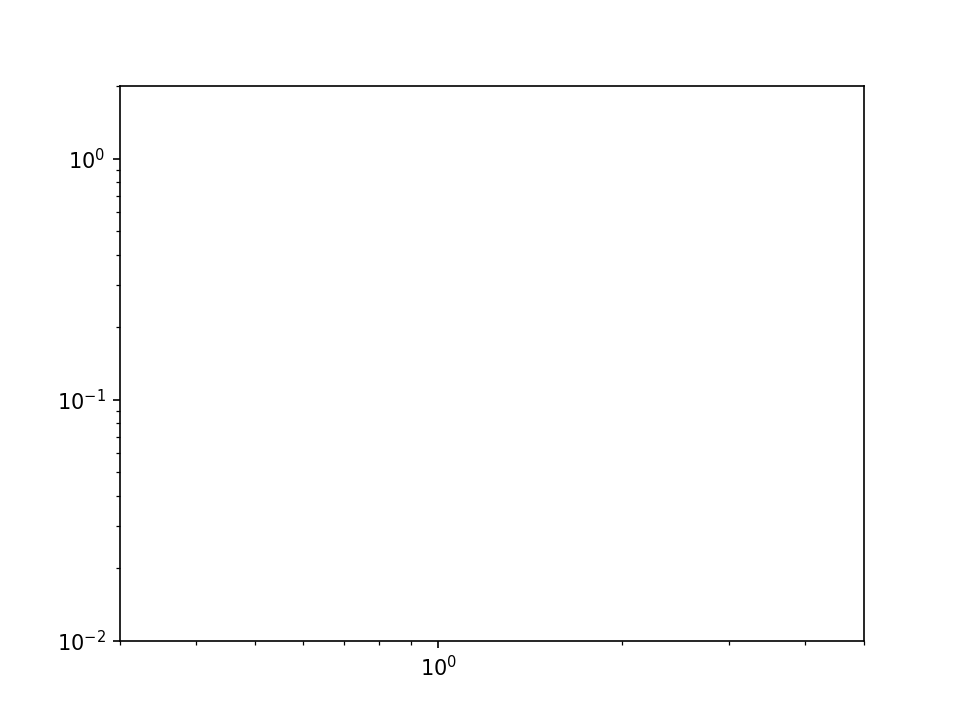

(0.3, 5)

In [34]:
plt.figure()
plt.plot(s['w'][0,:],s['tau_aero'][i,:],'-')
plt.plot(s['w'][0,sai],s['tau_aero'][i,sai],'.')
#plt.plot(wvl,s['aod'][i,:],'x-')
plt.plot(wvl,np.exp(np.polyval(pl,np.log(wvl))))

plt.yscale('log')
plt.xscale('log')
plt.ylim(0.01,2)
plt.xlim(0.3,5)


In [29]:
from scipy import polyfit

In [30]:
tau_aero_good = np.array([np.append(s['tau_aero_subtract_all'][i,saii],[s['tau_aero_subtract_all'][i,saii][-1]*2.0/3.0,
                                                           s['tau_aero_subtract_all'][i,saii][-1]/2.0,s['tau_aero_subtract_all'][i,saii][-1]/10.0]) \
                          for i in xrange(len(s['t']))])

In [31]:
poly = np.array([polyfit(np.log(np.append(s['w'][0,saii],[2.2,2.7,3.7])),np.log(aodd),2) for aodd in tau_aero_good])

In [32]:
poly.shape

(19716, 3)

In [33]:
s['paod'] = np.zeros((len(s['utc']),len(wvl)))
for i in xrange(len(s['utc'])):
    s['paod'][i,:] = np.exp(np.polyval(poly[i,:],np.log(wvl)))


<IPython.core.display.Javascript object>


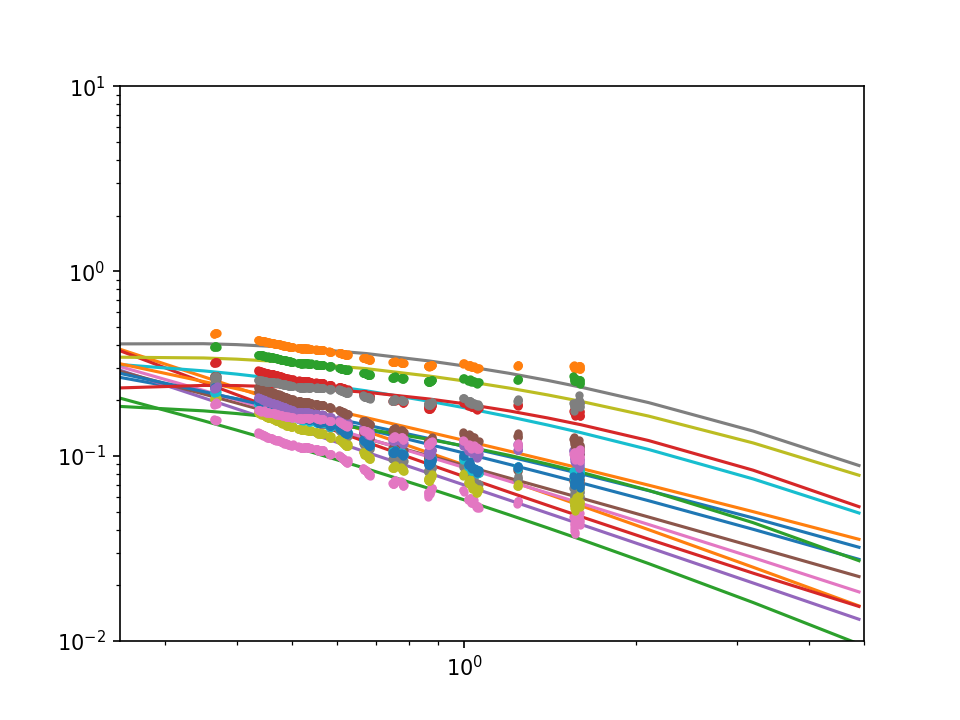

(0.25, 5)

In [46]:
plt.figure()
plt.plot(wvl,s['paod'][flag,:].T[:,10:-1:500])
plt.plot(s['w'][0,saii],s['tau_aero'][:,saii][flag,:].T[:,10:-1:500],'.')
plt.ylim(0,1)
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.01,10)
plt.xlim(0.25,5)

In [47]:
s['aod'] = s['paod']

In [110]:
i=3778

In [113]:
s['aod'][i,3]

0.1514611779985442

In [115]:
s['Alt'][i]

array([914.34], dtype=float32)

## Load the in situ files

In [48]:
situ = pd.read_csv(fp+'data_other/{}_nephclap.csv'.format(day))

In [9]:
situ

DateTimeUTC  totScat_450nm  totScatCalc_500nm  totScat_550nm  \
0      2018-06-18 14:18:00           1.27           1.101986           0.94   
1      2018-06-18 14:19:00           1.58           1.381543           1.28   
2      2018-06-18 14:20:00           1.82           1.601093           1.43   
3      2018-06-18 14:21:00           2.22           1.588274           1.22   
4      2018-06-18 14:22:00           2.53           1.926640           1.48   
5      2018-06-18 14:22:03           2.53           1.926640           1.48   
6      2018-06-18 14:22:04           2.53           1.926640           1.48   
7      2018-06-18 14:22:06           2.53           1.926640           1.48   
8      2018-06-18 14:23:00           1.38           1.279665           1.99   
9      2018-06-18 14:23:04           1.38           1.279665           1.99   
10     2018-06-18 14:23:05           3.30                NaN           0.65   
11     2018-06-18 14:23:06           3.61           2.109136           1.33   
12     2018-06-18 14:23:07           3.48           2.127818           1.20   
13     2018-06-18 14:23:08           4.24           2.592878           1.41   
14     2018-06-18 14:23:09           4.34           2.779356           1.87   
15     2018-06-18 14:23:10           4.63           3.178104           2.65   
16     2018-06-18 14:23:11           3.46                NaN           2.93   
17     2018-06-18 14:23:12           3.56                NaN           2.86   
18     2018-06-18 14:23:13           3.29                NaN           2.24   
19     2018-06-18 14:23:14           3.63           2.888479           2.35   
20     2018-06-18 14:23:15           3.37           2.582513           1.80   
21     2018-06-18 14:23:16           3.78           2.684500           1.59   
22     2018-06-18 14:23:17           3.25           2.201110           1.11   
23     2018-06-18 14:23:18           2.64           1.908776           1.37   
24     2018-06-18 14:23:19           2.02                NaN           0.93   
25     2018-06-18 14:23:20           3.04                NaN           1.26   
26     2018-06-18 14:23:21           2.68                NaN           1.57   
27     2018-06-18 14:23:22           3.41           2.426903           1.99   
28     2018-06-18 14:23:23           2.76           1.896510           1.65   
29     2018-06-18 14:23:24           4.35           2.662850           1.90   
...                    ...            ...                ...            ...   
15720  2018-06-18 18:44:55           5.16                NaN           2.93   
15721  2018-06-18 18:44:56           6.86                NaN           3.80   
15722  2018-06-18 18:44:57           7.13           4.746515           3.20   
15723  2018-06-18 18:44:58           6.49           4.341035           3.71   
15724  2018-06-18 18:44:59           4.89           3.593480           2.96   
15725  2018-06-18 18:45:00           6.19           4.093452           2.80   
15726  2018-06-18 18:45:01           4.59           3.357170           3.00   
15727  2018-06-18 18:45:02           5.23           3.688325           2.64   
15728  2018-06-18 18:45:03           4.12           2.857476           1.76   
15729  2018-06-18 18:45:04           4.53           3.209057           1.81   
15730  2018-06-18 18:45:05           4.14           2.736847           1.28   
15731  2018-06-18 18:45:06           6.04           3.906169           2.02   
15732  2018-06-18 18:45:07           6.52           4.291297           2.39   
15733  2018-06-18 18:45:08           6.79           4.533767           3.41   
15734  2018-06-18 18:45:09           5.69           3.900915           2.59   
15735  2018-06-18 18:45:10           6.67           4.923950           3.36   
15736  2018-06-18 18:45:11           5.42           3.847654           2.45   
15737  2018-06-18 18:45:12           5.26           3.151915           1.41   
15738  2018-06-18 18:45:13           3.49           2.223906     

In [49]:
insitu = situ.to_dict('list')

In [50]:
insitu.keys()

['totScat_450nm',
 'totScat_700nm',
 'scatFitSlope',
 'totScat_550nm',
 'totAbs_528nm',
 'totAbs_467nm',
 'totAbsCalc_500nm',
 'totAbs_652nm',
 'totScatCalc_500nm',
 'DateTimeUTC',
 'angScat',
 'angAbs',
 'absFitSlope',
 'extCalc500nm',
 'absFitIncpt',
 'scatFitIncpt']

In [51]:
insitu['ssa_500nm'] = np.array(insitu['totScatCalc_500nm'])/np.array(insitu['extCalc500nm'])

In [52]:
insitu['extCalc500nm'] = np.array(insitu['extCalc500nm'])

In [53]:
gu = pd.to_datetime(situ['DateTimeUTC']).to_list()
insitu['utc'] = np.array([g.hour+g.minute/60.0+g.second/3600.0 for g in gu])

<IPython.core.display.Javascript object>


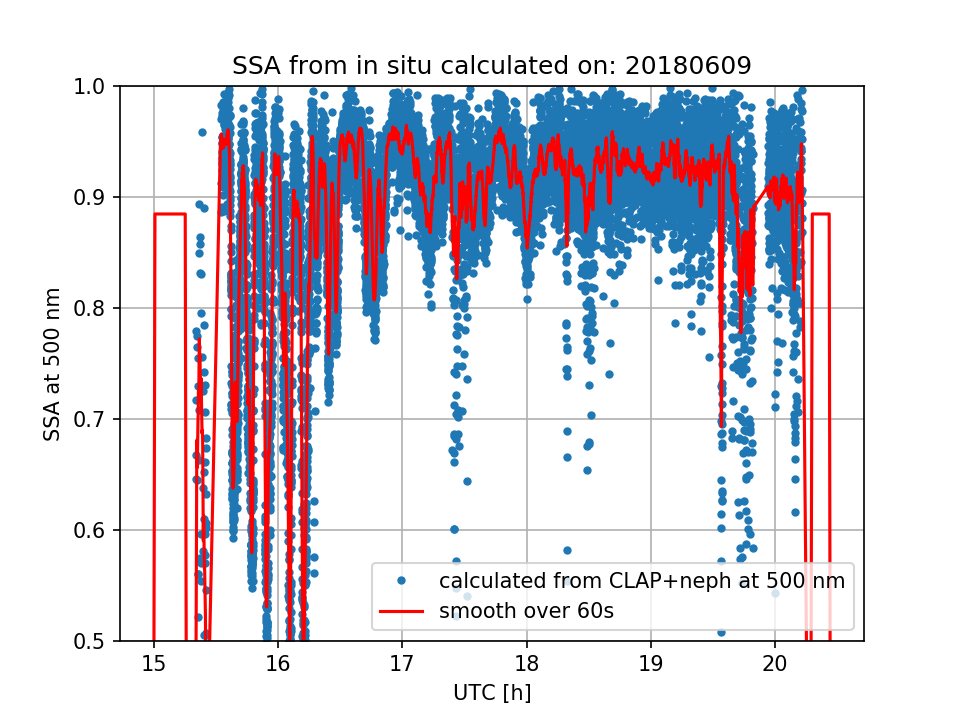

In [54]:
plt.figure()
plt.plot(insitu['utc'],insitu['ssa_500nm'],'.',label='calculated from CLAP+neph at 500 nm')
plt.plot(insitu['utc'],Sp.smooth(insitu['ssa_500nm'],60,old=True),'-r',label='smooth over 60s')
plt.legend()
plt.xlabel('UTC [h]')
plt.ylabel('SSA at 500 nm')
plt.title('SSA from in situ calculated on: {}'.format(day))
plt.ylim(0.5,1.0)
plt.grid()
#plt.savefig(fp+'plots/SSA_500_CLAP_neph_smooth_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


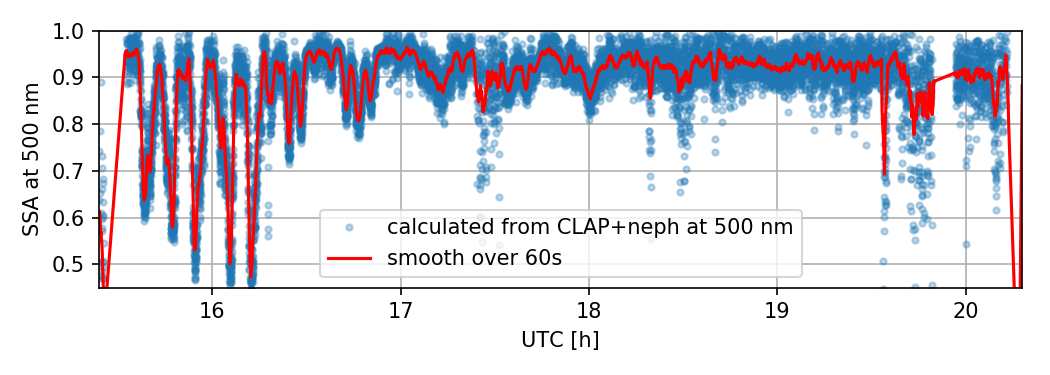

In [634]:
plt.figure(figsize=(7,2.5))
plt.plot(insitu['utc'],insitu['ssa_500nm'],'.',alpha=0.3,label='calculated from CLAP+neph at 500 nm')
plt.plot(insitu['utc'],Sp.smooth(insitu['ssa_500nm'],60,old=True),'-r',label='smooth over 60s')
plt.legend()
plt.xlabel('UTC [h]')
plt.ylabel('SSA at 500 nm')
#plt.title('SSA from in situ calculated on: {}'.format(day))
plt.ylim(0.45,1.0)
plt.xlim(15.4,20.3)
plt.grid()
plt.tight_layout()
plt.savefig(fp+'plots/SSA_500_CLAP_neph_smooth_transp_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

In [55]:
ssa_insitu = Sp.smooth(insitu['ssa_500nm'],60,old=True)

In [56]:
len(ssa_insitu)

19601

### Apply Altitude change filter

Need to load the 4STAR spectra, then run the next cell first

In [57]:
f_alt = interp1d(x=s['utc'],y=s['Alt'][:,0])
insitu['alt'] = f_alt(insitu['utc'])

<IPython.core.display.Javascript object>


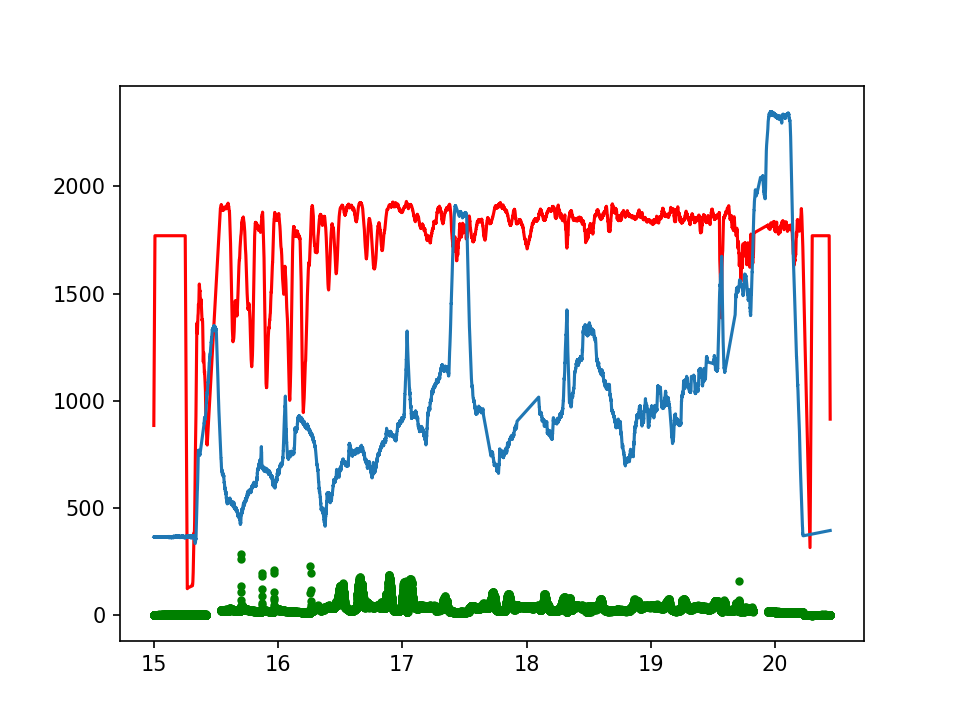

In [58]:
plt.figure()
plt.plot(insitu['utc'],Sp.smooth(insitu['ssa_500nm']*2000.0,60,old=True),'-r')
plt.plot(insitu['utc'],insitu['totScat_550nm'],'.g')
plt.plot(insitu['utc'],insitu['alt'])

In [59]:
def running_std(x,n):
    'Function to do a running standard deviation on array (x) with window size (n)'
    q = x**2
    try: 
        q = np.convolve(q, np.ones((n, )), mode="valid")
    except ValueError:
        x = x.flatten()
        q = x**2
        q = np.convolve(q, np.ones((n, )), mode="valid")        
    s = np.convolve(x, np.ones((n, )), mode="valid")
    o = (q-s**2/n)/float(n-1)
    return o 

In [60]:
nbox=30

In [61]:
std_alt = running_std(insitu['alt'],nbox)

In [62]:
infl = np.where(std_alt<50)[0]
infl_not = np.where(std_alt>50)[0]

In [63]:
insitu['ssa_500nm'][infl].shape

(11061,)

In [64]:
insitu['ssa_500nm'].shape

(19601,)

In [65]:
ssa_in = insitu['ssa_500nm'][:]*2.0
ssa_in[infl_not] = np.nan
ssa_in = ssa_in/2.0

In [141]:
ssa_in.shape

(19601,)

In [67]:
#xout = np.convolve(x, np.ones(window)/window, 'same')
window = 15
xmasked, mask = Sp.nanmasked(ssa_in)
fx = interpolate.interp1d(insitu['utc'][mask],xmasked,bounds_error=False)
xinterp = fx(insitu['utc'])
ssaout = np.convolve(xinterp, np.ones(window)/window, 'same')

ssaout[~mask] = np.nan

#ssaout = np.convolve(ssa_in,np.ones(30)/30,'same')

<IPython.core.display.Javascript object>


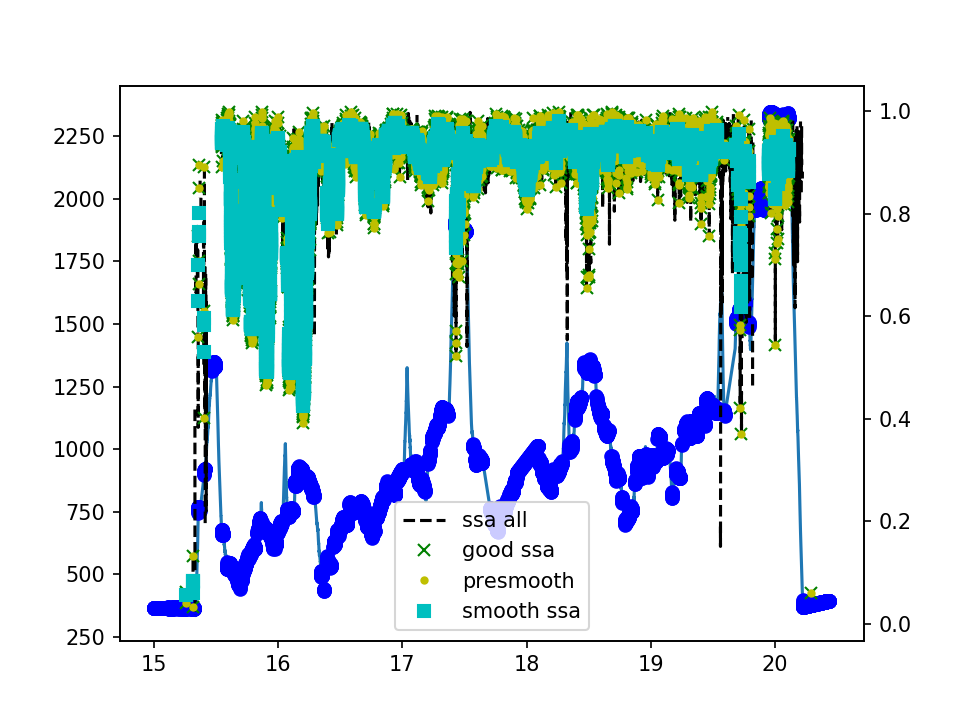

In [68]:
fig,ax1 = plt.subplots()

ax1.plot(insitu['utc'],insitu['alt'],label='alt all')
ax1.plot(insitu['utc'][infl],insitu['alt'][infl],'ob',label='good alt')

ax2 = ax1.twinx()
ax2.plot(insitu['utc'],insitu['ssa_500nm'],'--k',label='ssa all')
ax2.plot(insitu['utc'][infl],insitu['ssa_500nm'][infl],'xg',label='good ssa')
ax2.plot(insitu['utc'],ssa_in,'.y',label='presmooth')
ax2.plot(insitu['utc'],ssaout,'sc',label='smooth ssa')

plt.legend()

<IPython.core.display.Javascript object>


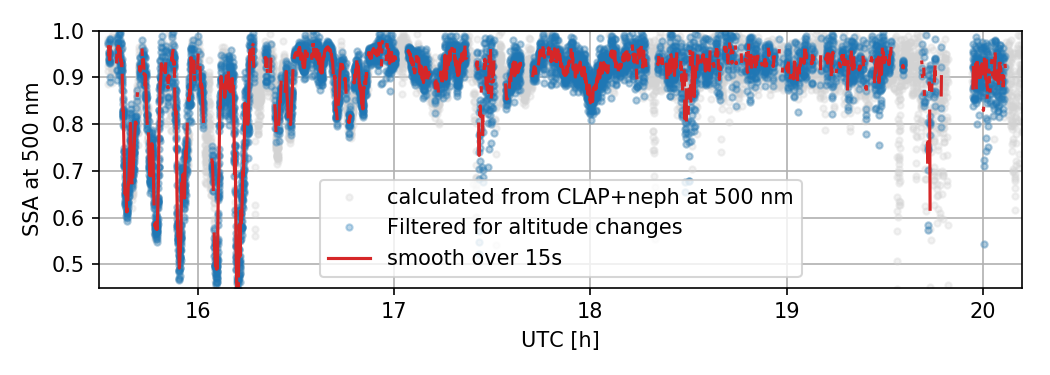

In [69]:
plt.figure(figsize=(7,2.5))
plt.plot(insitu['utc'],insitu['ssa_500nm'],'.',color='lightgrey',alpha=0.3,label='calculated from CLAP+neph at 500 nm')
plt.plot(insitu['utc'][infl],insitu['ssa_500nm'][infl],'.',alpha=0.3,label='Filtered for altitude changes')
plt.plot(insitu['utc'],ssaout,'-',color='tab:red',label='smooth over 15s')
plt.legend()
plt.xlabel('UTC [h]')
plt.ylabel('SSA at 500 nm')
#plt.title('SSA from in situ calculated on: {}'.format(day))
plt.ylim(0.45,1.0)
plt.xlim(15.5,20.2)
plt.grid()
plt.tight_layout()
plt.savefig(fp+'plots/SSA_500_CLAP_neph_smooth_transp_filtered_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

In [142]:
ssa_insitu = ssaout

<IPython.core.display.Javascript object>


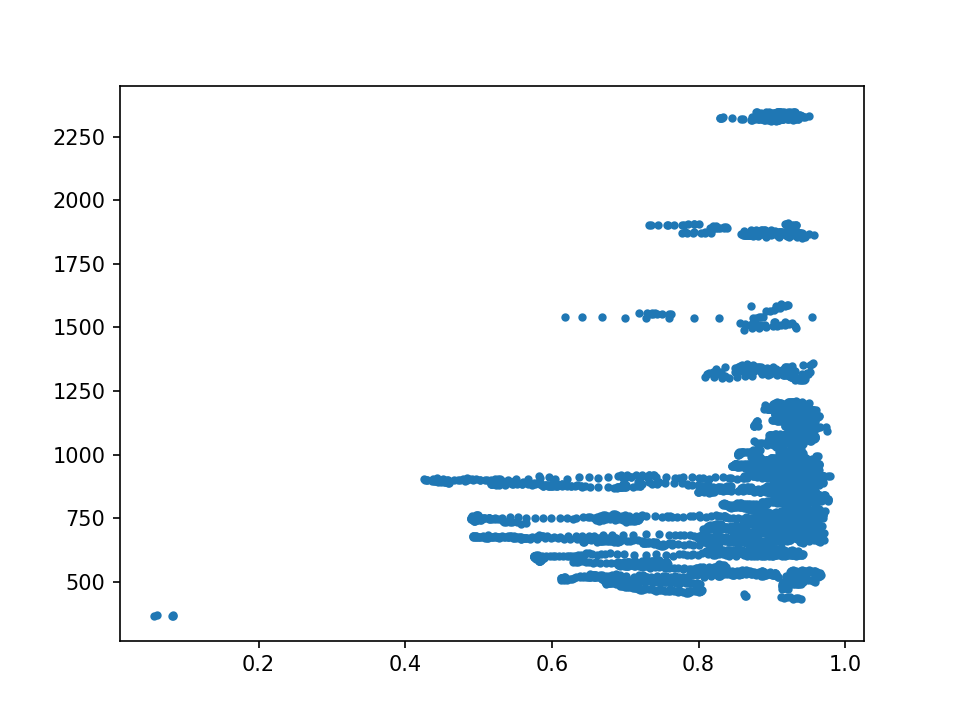

In [144]:
plt.figure()
plt.plot(ssa_insitu,insitu['alt'],'.')

## Load the UHSAS files

In [71]:
uh = sio.loadmat(fp+'data_other/{}_UHSAS_ECCC.mat'.format(day))

/home/sam/.local/lib/python2.7/site-packages/scipy/io/matlab/mio.py:208: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [72]:
uh.keys()

['None',
 '__globals__',
 '__function_workspace__',
 'instr',
 '__header__',
 'binDataConc',
 't',
 '__version__',
 'binFrom',
 'binTo']

In [73]:
uh['utc'] = lu.toutc(lu.mat2py_time(uh['t']))

In [74]:
uh['utc'].shape

(18391,)

In [75]:
uh['binDataConc'].sum(axis=1).shape

(18391,)

In [76]:
uh['nConc'] = uh['binDataConc'].sum(axis=1)

<IPython.core.display.Javascript object>


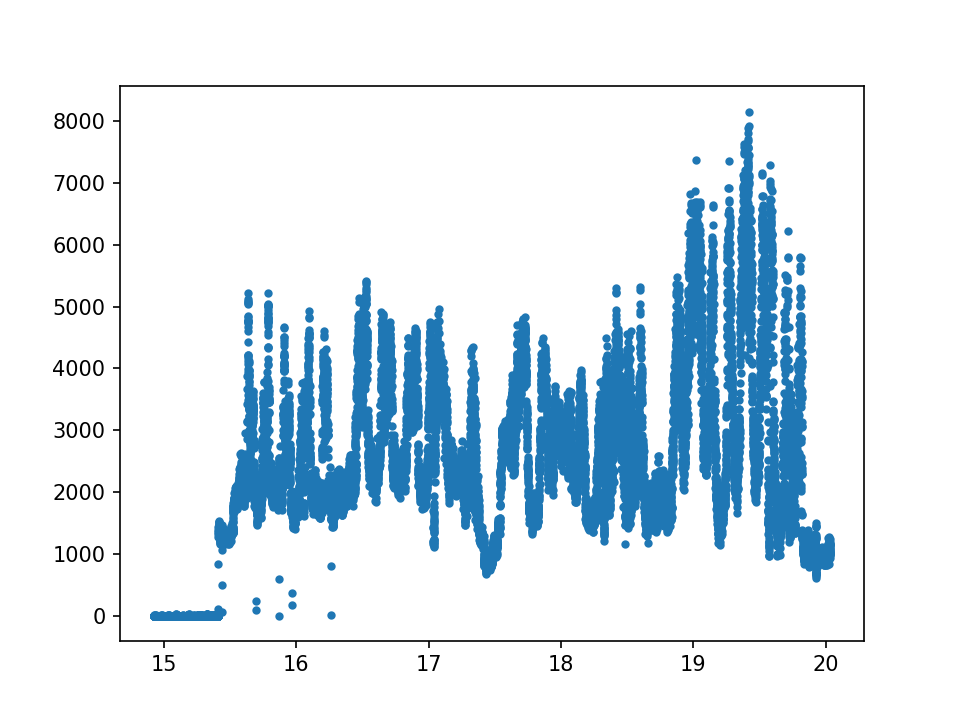

In [77]:
plt.figure()
plt.plot(uh['utc'],uh['binDataConc'].sum(axis=1),'.')

### Build a file for quick mie calculations

In [462]:
np.argmin(abs(uh['utc']-16.527))

5770

In [454]:
uh['binDataConc'].shape

(18391, 99)

<IPython.core.display.Javascript object>


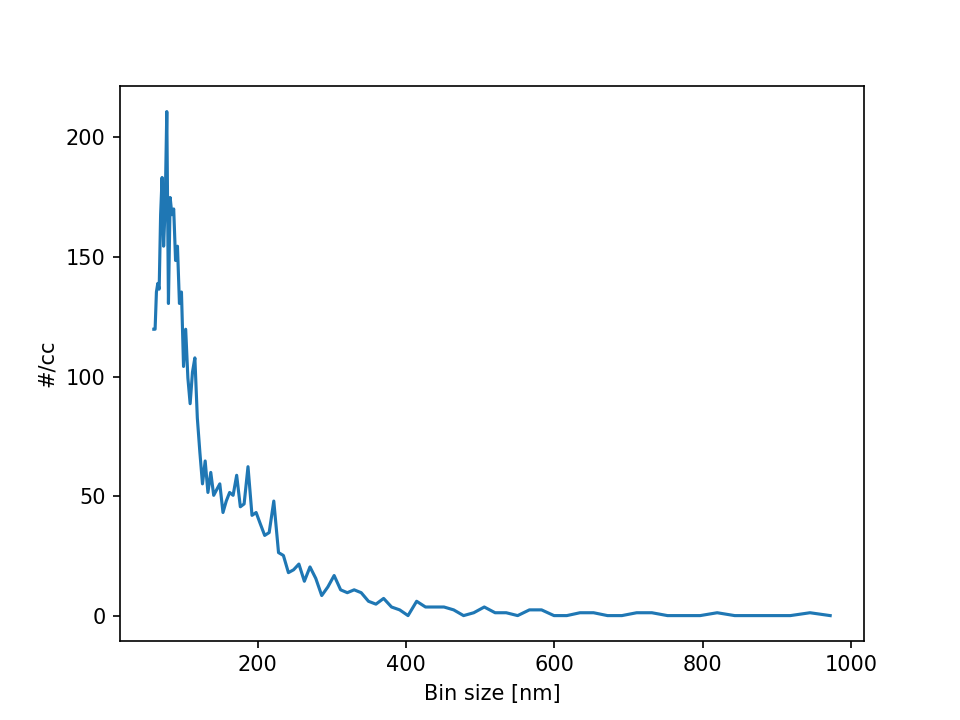

Text(0,0.5,'#/cc')

In [463]:
plt.figure()
plt.plot(uh['binFrom'][0,:],uh['binDataConc'][5770,:])
plt.xlabel('Bin size [nm]')
plt.ylabel('#/cc')

In [466]:
bin_averages = (uh['binFrom'][0,:] +uh['binTo'][0,:])/2.0/1000.0 #in micron

In [467]:
bin_averages 

array([0.060865, 0.06262 , 0.064425, 0.06628 , 0.06819 , 0.070155,
       0.07218 , 0.074265, 0.076405, 0.078605, 0.08087 , 0.0832  ,
       0.0856  , 0.08807 , 0.090605, 0.093215, 0.095905, 0.09867 ,
       0.101515, 0.10444 , 0.10745 , 0.11055 , 0.113735, 0.11701 ,
       0.120385, 0.123855, 0.127425, 0.1311  , 0.134875, 0.138765,
       0.142765, 0.14688 , 0.151115, 0.15547 , 0.159955, 0.164565,
       0.169305, 0.174185, 0.179205, 0.18437 , 0.189685, 0.195155,
       0.200785, 0.206575, 0.212525, 0.21865 , 0.224955, 0.23144 ,
       0.23811 , 0.24497 , 0.252035, 0.2593  , 0.266775, 0.274465,
       0.282375, 0.290515, 0.29889 , 0.30751 , 0.316375, 0.325495,
       0.334875, 0.344525, 0.354455, 0.364675, 0.37519 , 0.386005,
       0.39713 , 0.408575, 0.420355, 0.432475, 0.44494 , 0.457765,
       0.47096 , 0.484535, 0.498505, 0.512875, 0.527655, 0.542865,
       0.558515, 0.574615, 0.59118 , 0.60822 , 0.62575 , 0.64379 ,
       0.66235 , 0.68144 , 0.701085, 0.721295, 0.742085, 0.763

In [468]:
fp

u'/data/sam/COSR/'

In [479]:
with open(fp+'data_other/UHSAS_sizedistr_{}.dat'.format(day),'w') as f:
    for j,r in enumerate(bin_averages):
        f.write('{:0.7f} {:3.7f}\n'.format(r,uh['binDataConc'][5770,j]))

In [480]:
wvl

array([0.25 , 0.35 , 0.4  , 0.5  , 0.675, 0.87 , 0.995, 1.2  , 1.4  ,
       1.6  , 2.1  , 3.2  , 4.9  ])

### Read the mie calc

File input to mie code from libradtran 2.0.2:
    
    mie_program MIEV0
    refrac user 1.60 0.0032
    size_distribution_file /data/sam/COSR/data_other/UHSAS_sizedistr_20180609.dat
    wavelength /data/sam/COSR/data_other/mie_cal_wavelengths.dat
    
Command:

    ~/libradtran/libRadtran-2.0.2/bin/mie < mie_aero.inp > mie_aero.out

In [483]:
mie_out = np.genfromtxt(fp+'data_other/mie_aero.out')

In [484]:
mie_out

array([[ 2.500000e+02,  1.600000e+00,  3.200000e-03,  5.589048e+03,
         9.456897e-01,  6.585863e-01, -1.000000e+00],
       [ 3.500000e+02,  1.600000e+00,  3.200000e-03,  5.858064e+03,
         9.614351e-01,  6.495259e-01, -1.000000e+00],
       [ 4.000000e+02,  1.600000e+00,  3.200000e-03,  5.961208e+03,
         9.658072e-01,  6.509054e-01, -1.000000e+00],
       [ 5.000000e+02,  1.600000e+00,  3.200000e-03,  5.802865e+03,
         9.712858e-01,  6.443503e-01, -1.000000e+00],
       [ 6.750000e+02,  1.600000e+00,  3.200000e-03,  5.265337e+03,
         9.766520e-01,  6.318970e-01, -1.000000e+00],
       [ 8.700000e+02,  1.600000e+00,  3.200000e-03,  4.451127e+03,
         9.788519e-01,  6.109435e-01, -1.000000e+00],
       [ 9.950000e+02,  1.600000e+00,  3.200000e-03,  4.026268e+03,
         9.811907e-01,  6.097534e-01, -1.000000e+00],
       [ 1.200000e+03,  1.600000e+00,  3.200000e-03,  3.511961e+03,
         9.830812e-01,  6.170984e-01, -1.000000e+00],
       [ 1.400000e+03,  

In [487]:
mout = {}
mout['wvl'] = mie_out[:,0]
mout['refr'] = mie_out[:,1]
mout['refi'] = mie_out[:,2]
mout['qext'] = mie_out[:,3]
mout['ssa'] = mie_out[:,4]
mout['asy'] = mie_out[:,5]

## Load the flt table

In [78]:
fp

u'/data/sam/COSR/'

In [79]:
flttable = pd.read_excel(fp+'flt_table/fltable_{}.xlsx'.format(day))

In [323]:
flttable

YYYY  MM  DD  flNumNRC  flNumECCC       FlightType PlumeId  Facility  \
0   2018   6   9        28         14          takeoff     NaN       NaN   
1   2018   6   9        28         14   transformation     NaN       NaN   
2   2018   6   9        28         14         in plume       A       NaN   
3   2018   6   9        28         14         in plume       B       NaN   
4   2018   6   9        28         14   transformation     NaN       NaN   
5   2018   6   9        28         14         in plume       B       NaN   
6   2018   6   9        28         14         in plume       A       NaN   
7   2018   6   9        28         14   transformation     NaN       NaN   
8   2018   6   9        28         14         in plume       A       NaN   
9   2018   6   9        28         14         in plume       B       NaN   
10  2018   6   9        28         14   transformation     NaN       NaN   
11  2018   6   9        28         14         in plume       B       NaN   
12  2018   6   9        28         14         in plume       A       NaN   
13  2018   6   9        28         14        spiral up     NaN       NaN   
14  2018   6   9        28         14      spiral down     NaN       NaN   
15  2018   6   9        28         14   transformation     NaN       NaN   
16  2018   6   9        28         14         in plume       A       NaN   
17  2018   6   9        28         14         in plume       B       NaN   
18  2018   6   9        28         14             full     NaN       NaN   
19  2018   6   9        28         14         in plume       B       NaN   
20  2018   6   9        28         14         in plume       A       NaN   
21  2018   6   9        28         14   transformation     NaN       NaN   
22  2018   6   9        28         14   transformation     NaN       NaN   
23  2018   6   9        28         14         in plume       A       NaN   
24  2018   6   9        28         14         in plume       B       NaN   
25  2018   6   9        28         14   transformation     NaN       NaN   
26  2018   6   9        28         14         in plume       B       NaN   
27  2018   6   9        28         14         in plume       A       NaN   
28  2018   6   9        28         14   transformation     NaN       NaN   
29  2018   6   9        28         14         in plume       A       NaN   
30  2018   6   9        28         14         in plume       B       NaN   
31  2018   6   9        28         14        spiral up     NaN       NaN   
32  2018   6   9        28         14      spiral down     NaN       NaN   
33  2018   6   9        28         14   transformation     NaN       NaN   
34  2018   6   9        28         14         in plume       B       NaN   
35  2018   6   9        28         14         in plume       A       NaN   
36  2018   6   9        28         14  need to confirm     NaN       NaN   
37  2018   6   9        28         14             full     NaN       NaN   
38  2018   6   9        28         14   transformation     NaN       NaN   
39  2018   6   9        28         14   transformation     NaN       NaN   
40  2018   6   9        28         14   transformation     NaN       NaN   
41  2018   6   9        28         14   transformation     NaN       NaN   
42  2018   6   9        28         14        spiral up     NaN       NaN   
43  2018   6   9        28         14      spiral down     NaN       NaN   
44  2018   6   9        28         14   transformation     NaN       NaN   
45  2018   6   9        28         14   transformation     NaN       NaN   
46  2018   6   9        28         14   transformation     NaN       NaN   
47  2018   6   9        28         14   transformation     NaN       NaN   
48  2018   6   9        28         14   transformation     NaN       NaN   
49  2018   6   9        28         14        spiral up     NaN       NaN   
50  2018   6   9        28         14      spiral down     NaN       NaN   
51  2018   6   9        28         14  need to confi

In [80]:
fromtime = flttable['FromTime'][flttable['FlightType']=='in plume']

In [81]:
totime = flttable['ToTime'][flttable['FlightType']=='in plume']

In [82]:
tt = fromtime.to_numpy()

In [83]:
tt[0].second

52

In [84]:
def time_utc(x):
    return np.array([y.hour+y.minute/60.0+y.second/3600.0 for y in x])

In [85]:
from_utc = time_utc(fromtime.to_numpy())
to_utc = time_utc(totime.to_numpy())

## Load the solar spectrum

In [615]:
fp_librad

u'/home/sam/libradtran/libRadtran-2.0.2b/data/'

In [616]:
sol = np.genfromtxt(fp_librad+'solar_flux/kurudz_1.0nm.dat')

In [617]:
sol.shape

(9751, 2)

<IPython.core.display.Javascript object>


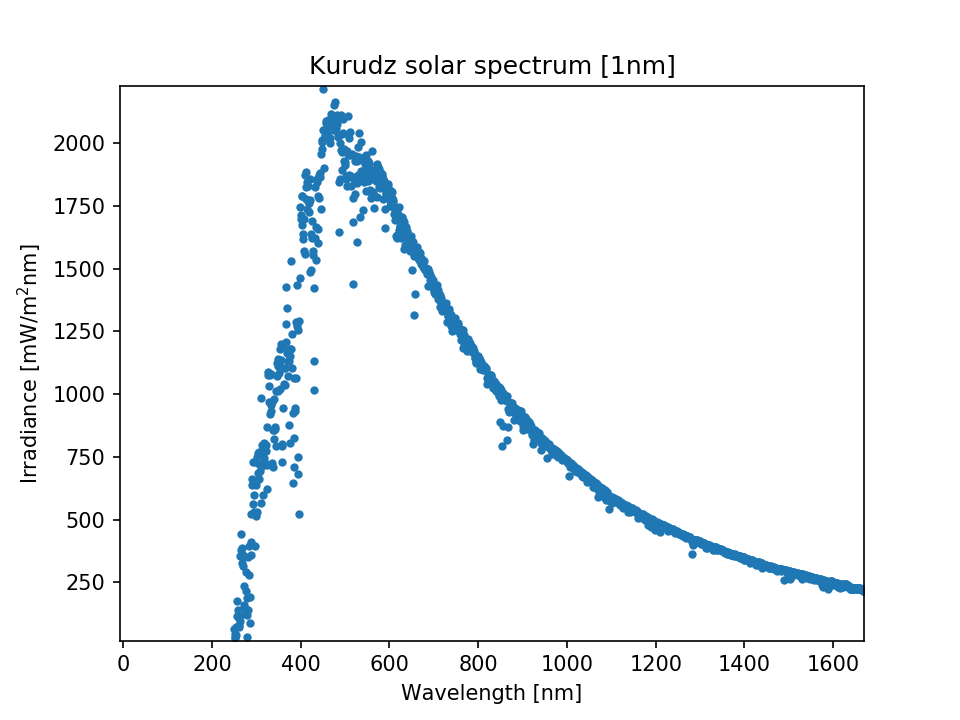

Text(0.5,0,'Wavelength [nm]')

In [619]:
plt.figure()
plt.plot(sol[:,0],sol[:,1],'.')
plt.ylabel('Irradiance [mW/m$^2$nm]')
plt.title('Kurudz solar spectrum [1nm]')
plt.xlabel('Wavelength [nm]')

In [620]:
sol[:,1].sum()

1365801.1692718002

<IPython.core.display.Javascript object>


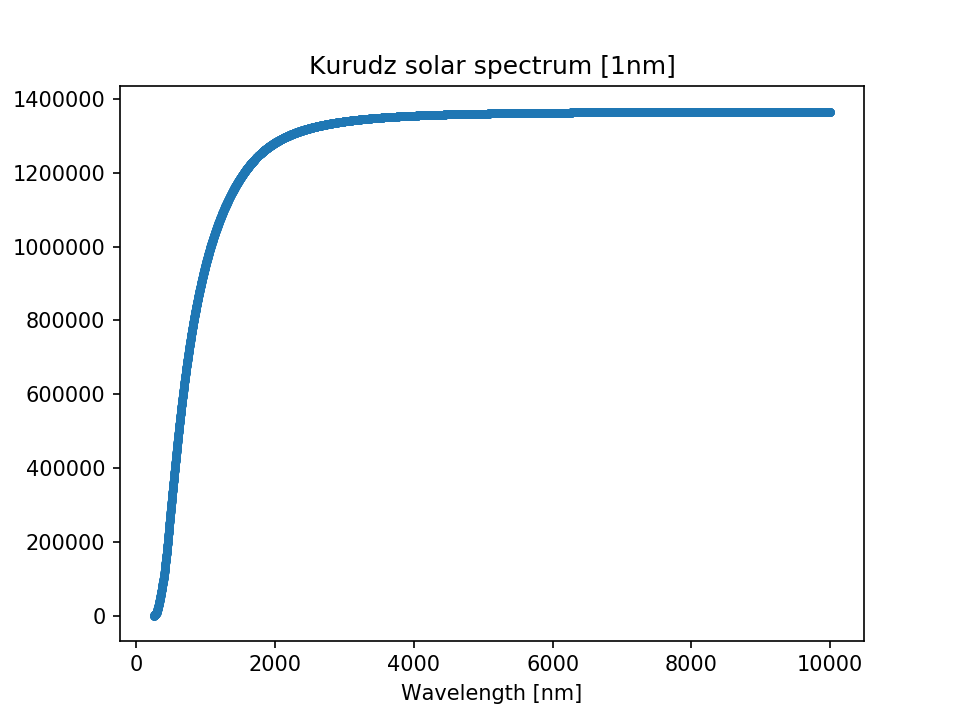

Text(0.5,0,'Wavelength [nm]')

In [623]:
plt.figure()
plt.plot(sol[:,0],sol[:,1].cumsum(),'.')
plt.ylabel('Cumulative Irradiance [mW/m$^2$nm]')
plt.title('Kurudz solar spectrum [1nm]')
plt.xlabel('Wavelength [nm]')

<IPython.core.display.Javascript object>


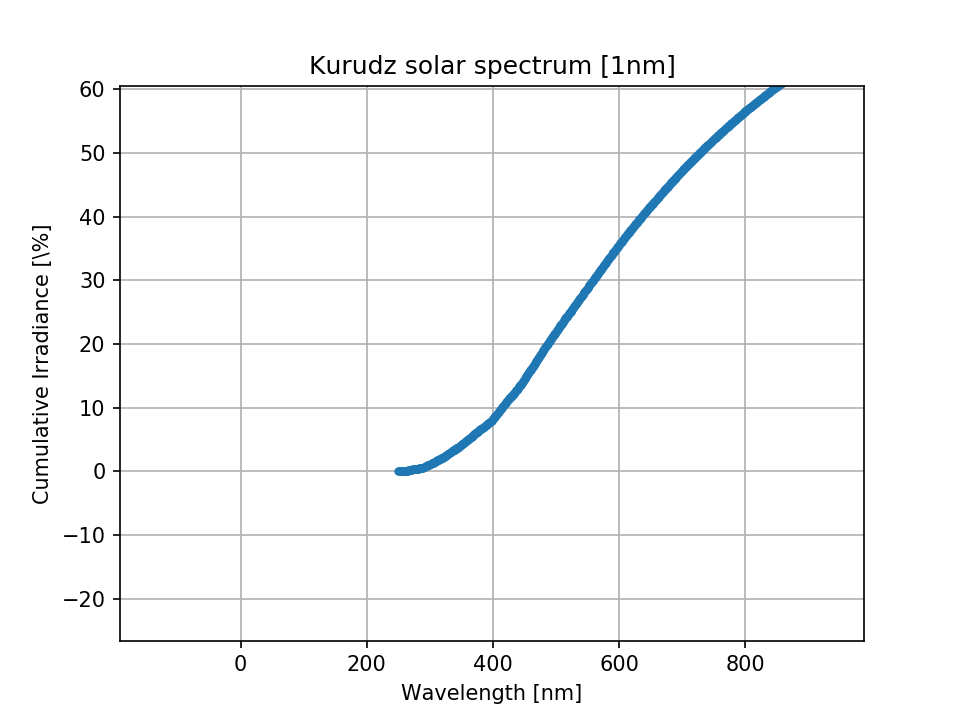

In [624]:
plt.figure()
plt.plot(sol[:,0],sol[:,1].cumsum()/sol[:,1].sum()*100.0,'.')
plt.ylabel('Cumulative Irradiance [\%]')
plt.title('Kurudz solar spectrum [1nm]')
plt.xlabel('Wavelength [nm]')
plt.grid()

## Load the skyscan results

In [129]:
sk_names = {
    '20180624':'4STAR_20180624_135_SKYP.created_20190329_003621.ppl_lv15.mat',
    '20180625':'4STAR_20180625_026_SKYP.created_20190507_213718.ppl_lv15.mat',
    '20180620':'4STAR_20180620_017_SKYP.created_20190507_225712.ppl_lv15.mat',
    '20180618':'4STAR_20180618_029_SKYA.created_20190507_232752.avg_lv10.mat',
    '20180609':'4STAR_20180609_041_SKYP.created_20190508_003116.ppl_lv15.mat',
    '20180705':'4STAR_20180705_061_SKYP.created_20190508_003930.ppl_lv15.mat'}

In [130]:
sk_n = {
    '20180624':'135',
    '20180625':'026',
    '20180620':'017',
    '20180618':'029',
    '20180609':'041',
    '20180705':'061'}

In [131]:
fp_name = sk_names[day]#'4STAR_20180624_135_SKYP.created_20190329_003621.ppl_lv15.mat'

In [132]:
sky = sio.loadmat(fp+fp_name)
sky.keys()

['sky_radiances_pct_diff',
 'ext_fine',
 'flux_dn',
 'Sphericity_err',
 'Sphericity',
 'sky_radiances_angle',
 'sky_radiances_measured',
 'ssa_total',
 'radius',
 'flux_diffuse',
 'sfc_alb',
 'input_fname',
 'ssa_coarse',
 'sky_bias',
 'aaod',
 'fstem',
 'tod_fit',
 'output_fname',
 'g_coarse',
 'tod_meas',
 'input',
 'PF_coarse',
 'PF_total',
 'PF_fine',
 'aod',
 'g_fine',
 'refractive_index_real_r',
 'refractive_index_imaginary_r',
 'tod_meas_less_fit',
 'g_tot',
 'psd',
 'Wavelength',
 'PF_angle',
 '__version__',
 'ext_coarse',
 'ext_total',
 '__header__',
 '__globals__',
 'flux_up',
 'ssa_fine',
 'sky_radiances_fit',
 'sky_error']

In [133]:
sky['refractive_index_real_r']

array([[1.6],
       [1.6],
       [1.6],
       [1.6],
       [1.6]])

In [134]:
sky['refractive_index_imaginary_r']

array([[0.0032619],
       [0.0032489],
       [0.0032098],
       [0.0031842],
       [0.003181 ]])

# Plot out some data

## Plot out the retrieved skyscans

<IPython.core.display.Javascript object>


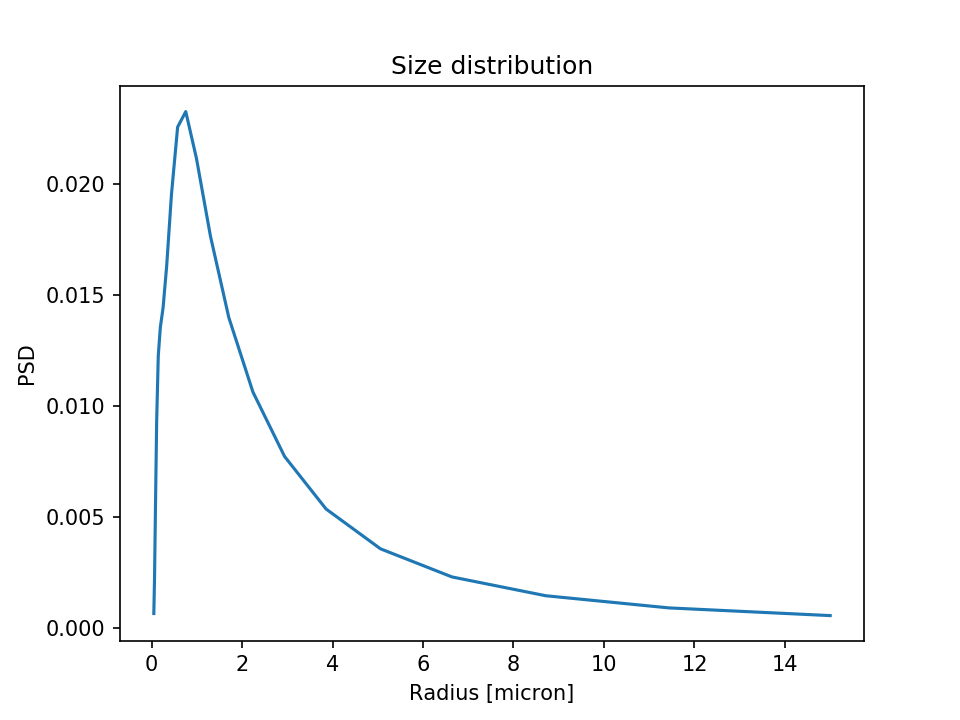

Text(0,0.5,'PSD')

In [451]:
plt.figure()
plt.plot(sky['radius'],sky['psd'])
plt.title('Size distribution')
plt.xlabel('Radius [micron]')
plt.ylabel('PSD')

<IPython.core.display.Javascript object>


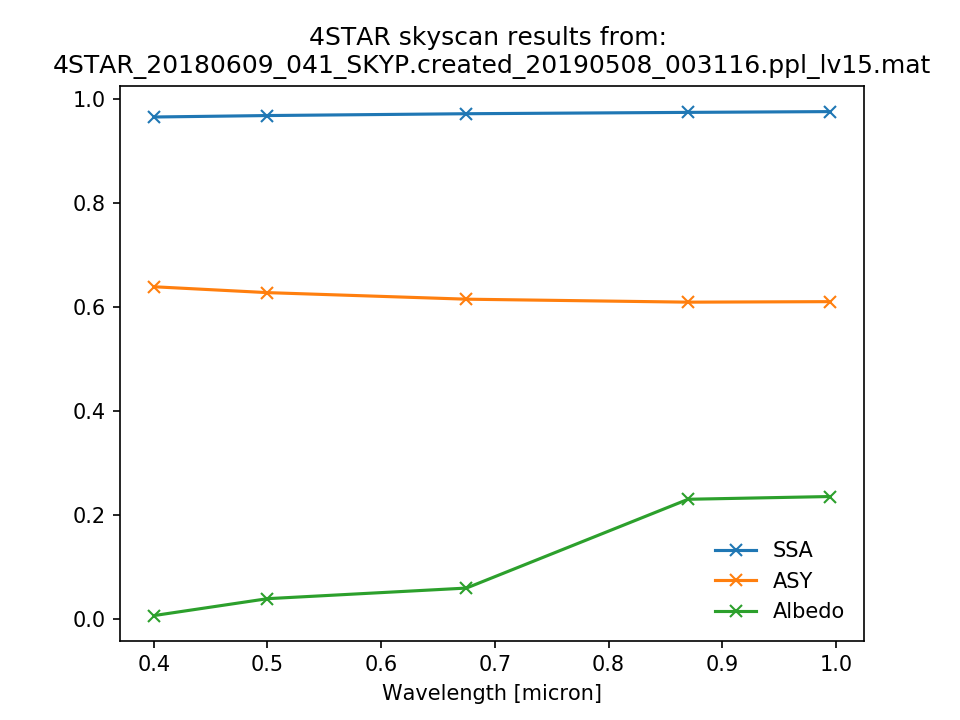

In [440]:
plt.figure()
plt.plot(sky['Wavelength'],sky['ssa_total'][0,:],'x-',label='SSA')
plt.plot(sky['Wavelength'],sky['g_tot'][0,:],'x-',label='ASY')
plt.plot(sky['Wavelength'],sky['sfc_alb'][0,:],'x-',label='Albedo')


plt.legend(frameon=False)
plt.xlabel('Wavelength [micron]')
plt.title('4STAR skyscan results from: \n' + fp_name)
plt.savefig(fp+'plots/4STAR_skyscan_result_{}_{}_{}_SKYP.png'.format(day,sk_n[day],vv),dpi=600,transparent=True)

In [135]:
sky['g_tot'][-1]

array([0.6382614 , 0.62695787, 0.6143521 , 0.60862112, 0.60960551])

## Expand the sky scans results to longer wavelengths

In [136]:
#wvl = np.array([0.35,0.4,0.5,0.675,0.87,0.995,1.2,1.4,1.6,2.1,4.0])
f_asy = interp1d(np.append(sky['Wavelength'][:,0],[2.0,2.6]),np.append(sky['g_tot'][0,:],[sky['g_tot'][0,-1]+0.008,sky['g_tot'][0,-1]-0.058]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
asy = f_asy(wvl)
f_ssa = interp1d(np.append(sky['Wavelength'][:,0],[1.5,2.0,2.3]),np.append(sky['ssa_total'][0,:],[sky['ssa_total'][0,-1]+0.003,sky['ssa_total'][0,-1]+0.0015,sky['ssa_total'][0,-1]-0.002]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
ssa = f_ssa(wvl)
f_alb = interp1d(np.append(np.append([0.25,0.35],sky['Wavelength'][:,0]),[1.65,2.2,3.0,5.0]),
                 np.append(np.append([0.01,0.01],sky['sfc_alb'][0,:]),[sky['sfc_alb'][0,-1]*0.5,sky['sfc_alb'][0,-1]*0.25,0.04,0.02]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
alb = f_alb(wvl)

In [70]:
# for 20180624 only
if day=='20180624':
    f_asy = interp1d(np.append(sky['Wavelength'][:,0],[1.1,2.4]),np.append(sky['g_tot'][0,:],[sky['g_tot'][0,-1]-0.01,sky['g_tot'][0,-1]-0.13]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
    asy = f_asy(wvl)
    f_ssa = interp1d(np.append(sky['Wavelength'][:,0],[1.1,1.2,1.3]),np.append(sky['ssa_total'][0,:],[sky['ssa_total'][0,-1]-0.012,sky['ssa_total'][0,-1]-0.022,sky['ssa_total'][0,-1]-0.034]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
    ssa = f_ssa(wvl)

In [162]:
if day=='20180625':
    f_asy = interp1d(np.append(sky['Wavelength'][:,0],[1.1,2.4]),np.append(sky['g_tot'][0,:],[sky['g_tot'][0,-1]-0.005,sky['g_tot'][0,-1]-0.008]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
    asy = f_asy(wvl)
    f_ssa = interp1d(np.append(sky['Wavelength'][:,0],[1.1,1.2,1.3]),np.append(sky['ssa_total'][0,:],[sky['ssa_total'][0,-1]-0.012,sky['ssa_total'][0,-1]-0.022,sky['ssa_total'][0,-1]-0.034]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
    ssa = f_ssa(wvl)

In [137]:
if day=='20180609':
    f_asy = interp1d(np.append(sky['Wavelength'][:,0],[1.1,2.4]),np.append(sky['g_tot'][0,:],[sky['g_tot'][0,-1]-0.002,sky['g_tot'][0,-1]-0.005]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
    asy = f_asy(wvl)
    f_ssa = interp1d(np.append(sky['Wavelength'][:,0],[1.1,1.2,1.3]),np.append(sky['ssa_total'][0,:],[sky['ssa_total'][0,-1]-0.008,sky['ssa_total'][0,-1]-0.016,sky['ssa_total'][0,-1]-0.020]),
                 bounds_error=False,fill_value='extrapolate',kind='slinear')
    ssa = f_ssa(wvl)

In [138]:
np.append(sky['ssa_total'][0,:],[sky['ssa_total'][0,-1]-0.008,sky['ssa_total'][0,-1]-0.002])

array([0.9648, 0.9676, 0.9711, 0.9737, 0.9752, 0.9672, 0.9732])

In [139]:
sky['Wavelength'][:,0]

array([0.4  , 0.5  , 0.675, 0.87 , 0.995])

In [140]:
sky['sfc_alb'][0,:]

array([0.005669, 0.038229, 0.058627, 0.229436, 0.234727])

<IPython.core.display.Javascript object>


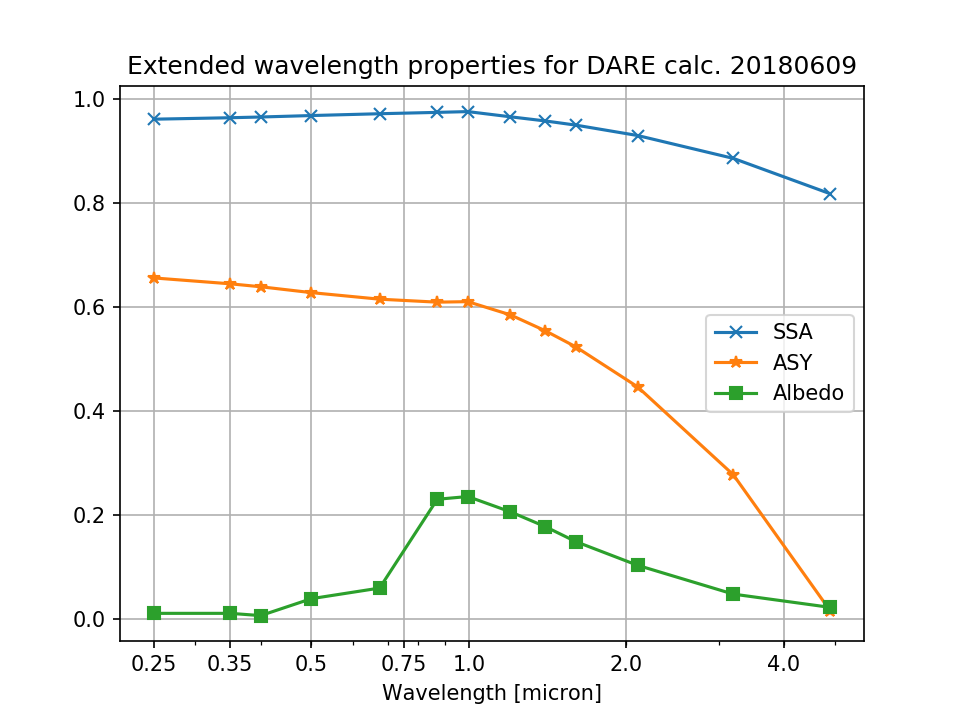

In [442]:
plt.figure()
plt.plot(wvl,ssa,'-x',label='SSA')
plt.plot(wvl,asy,'-*',label='ASY')
plt.plot(wvl,alb,'-s',label='Albedo')
plt.xscale('log')
plt.xticks([0.25,0.35,0.5,0.75,1.0,2.0,4.0],[0.25,0.35,0.5,0.75,1.0,2.0,4.0])
plt.grid()
plt.legend()
plt.xlabel('Wavelength [micron]')
plt.title('Extended wavelength properties for DARE calc. {}'.format(day))
plt.savefig(fp+'plots/AERO_prop_for_DARE_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


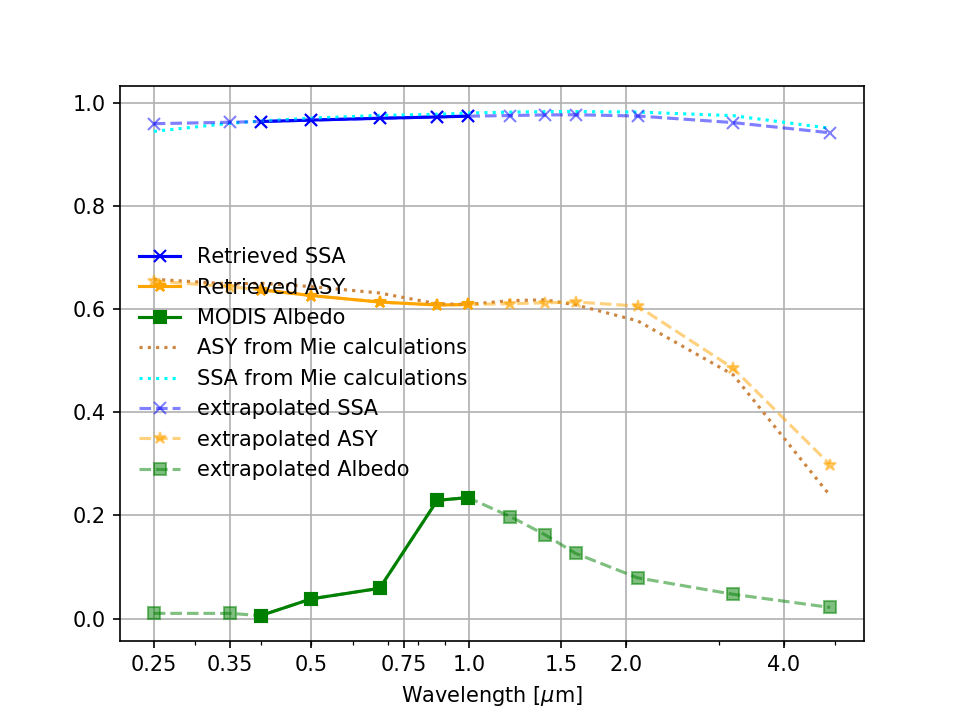

In [529]:
plt.figure()

plt.plot(sky['Wavelength'],sky['ssa_total'][0,:],'x-',color='b',label='Retrieved SSA')
plt.plot(sky['Wavelength'],sky['g_tot'][0,:],'*-',color='orange',label='Retrieved ASY')
plt.plot(sky['Wavelength'],sky['sfc_alb'][0,:],'s-',color='g',label='MODIS Albedo')

plt.plot(mout['wvl']/1000.0,mout['asy'],':',color='peru',label='ASY from Mie calculations')
plt.plot(mout['wvl']/1000.0,mout['ssa'],':',color='aqua',label='SSA from Mie calculations')

plt.plot(wvl,ssa,'--x',label='extrapolated SSA',color='b',alpha=0.5)
plt.plot(wvl,asy,'--*',label='extrapolated ASY',color='orange',alpha=0.5)
plt.plot(wvl,alb,'--s',label='extrapolated Albedo',color='g',alpha=0.5)
plt.xscale('log')
plt.xticks([0.25,0.35,0.5,0.75,1.0,1.5,2.0,4.0],[0.25,0.35,0.5,0.75,1.0,1.5,2.0,4.0])
plt.grid()
plt.legend(frameon=False,loc=6)
plt.xlabel('Wavelength [$\\mu$m]')
#plt.title('Extended wavelength properties for DARE calc. {}'.format(day))
plt.savefig(fp+'plots/AERO_prop_extrapolated_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

### Load the spectral albedo for grass

In [508]:
albg_wvl = np.genfromtxt(fp+'data_other/splib07a_Wavelengths_BECK_Beckman_0.2-3.0_microns.txt',skip_header=1)
albg_alb = np.genfromtxt(fp+'data_other/splib07a_Lawn_Grass_GDS91_green_BECKa_AREF.txt',skip_header=1)

In [513]:
albg_alb[albg_alb<0] = 0.0

<IPython.core.display.Javascript object>


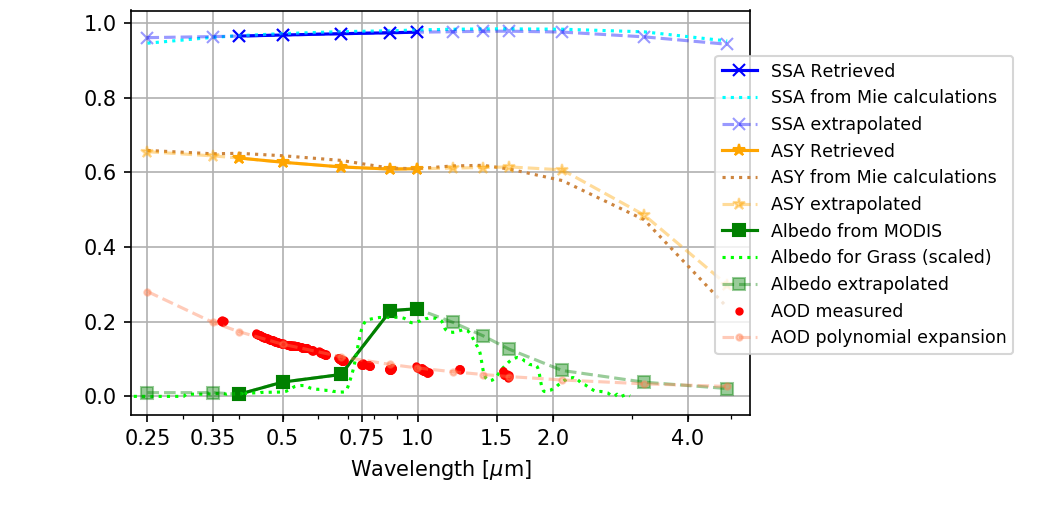

In [625]:
plt.figure(figsize=(7,3.5))

plt.plot(sky['Wavelength'],sky['ssa_total'][0,:],'x-',color='b',label='SSA Retrieved')
plt.plot(mout['wvl']/1000.0,mout['ssa'],':',color='aqua',label='SSA from Mie calculations')
plt.plot(wvl,ssa,'--x',label='SSA extrapolated',color='b',alpha=0.4)

plt.plot(sky['Wavelength'],sky['g_tot'][0,:],'*-',color='orange',label='ASY Retrieved')
plt.plot(mout['wvl']/1000.0,mout['asy'],':',color='peru',label='ASY from Mie calculations')
plt.plot(wvl,asy,'--*',label='ASY extrapolated',color='orange',alpha=0.4)

plt.plot(sky['Wavelength'],sky['sfc_alb'][0,:],'s-',color='g',label='Albedo from MODIS') #  [MCD43GF; Schaaf et al., ]
plt.plot(albg_wvl,albg_alb*0.3,':',color='lime',label='Albedo for Grass (scaled)') #[Kokaly et al., 2017]
plt.plot(wvl,alb,'--s',label='Albedo extrapolated',color='g',alpha=0.4)

i = 1201
plt.plot(s['w'][0,saii],s['tau_aero'][flag,:][i,saii],'.',color='red',label='AOD measured')
plt.plot(wvl,s['paod'][flag,:].T[:,i],'--.',color='coral',alpha=0.4,label='AOD polynomial expansion')

plt.xscale('log')
plt.xticks([0.25,0.35,0.5,0.75,1.0,1.5,2.0,4.0],[0.25,0.35,0.5,0.75,1.0,1.5,2.0,4.0])
plt.xlim(0.23,5.5)
plt.grid()

plt.xlabel('Wavelength [$\\mu$m]')
#plt.title('Extended wavelength properties for DARE calc. {}'.format(day))
plt.legend(frameon=True,bbox_to_anchor=(0.93,0.91),loc=2,fontsize='small')

box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0+0.1, box.width * 0.76, box.height])

plt.savefig(fp+'plots/AERO_prop_extrapolated_plusalb_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

## Get the vertical dependence of the extinction

In [86]:
f_alt = interp1d(x=s['utc'],y=s['Alt'][:,0])
insitu['alt'] = f_alt(insitu['utc'])

In [292]:
if day=='20180624':
    insitu['extCalc500nm'] = insitu['extCalc500nm']*10.0

In [258]:
if day=='20180609':
    insitu['extCalc500nm'] = insitu['extCalc500nm']*10.0

<IPython.core.display.Javascript object>


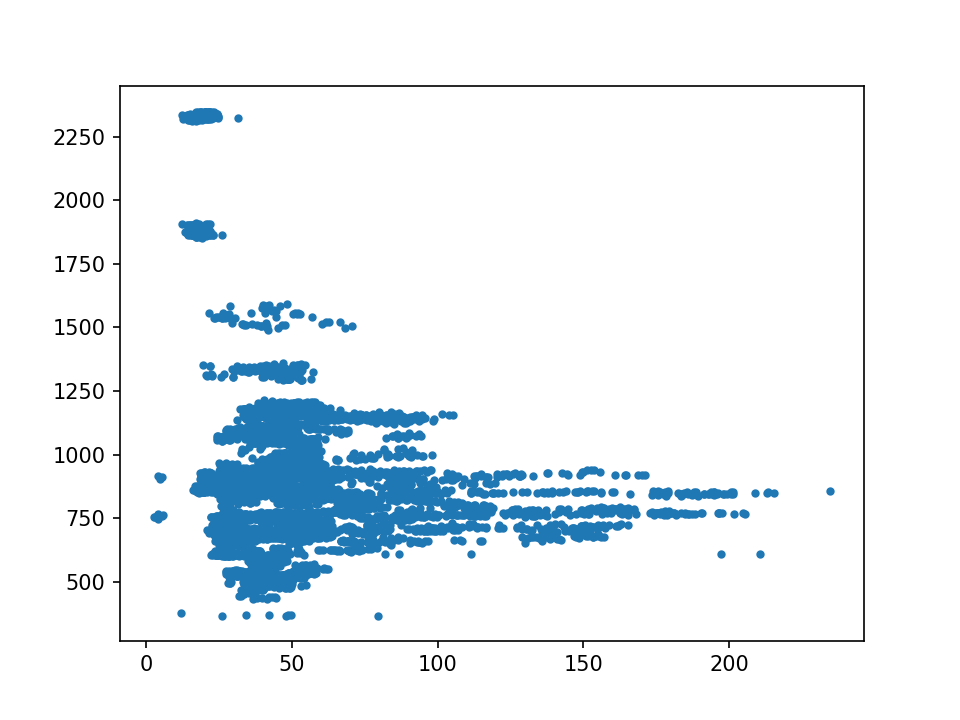

In [293]:
plt.figure()
plt.plot(insitu['extCalc500nm'][infl],insitu['alt'][infl],'.')

<IPython.core.display.Javascript object>


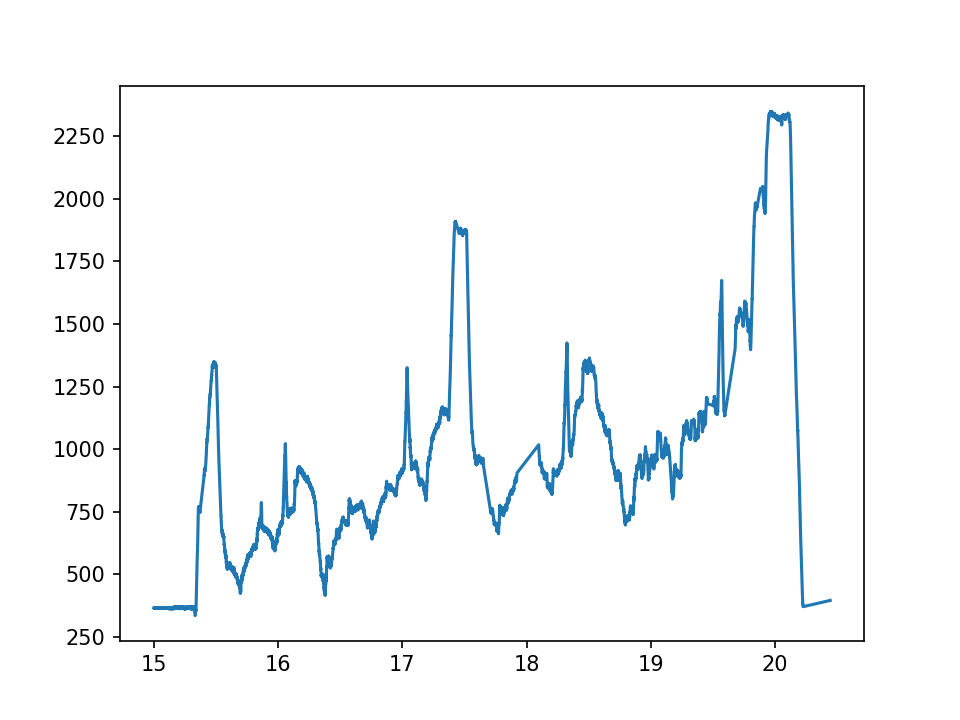

In [87]:
plt.figure()
plt.plot(insitu['utc'],insitu['alt'])

<IPython.core.display.Javascript object>


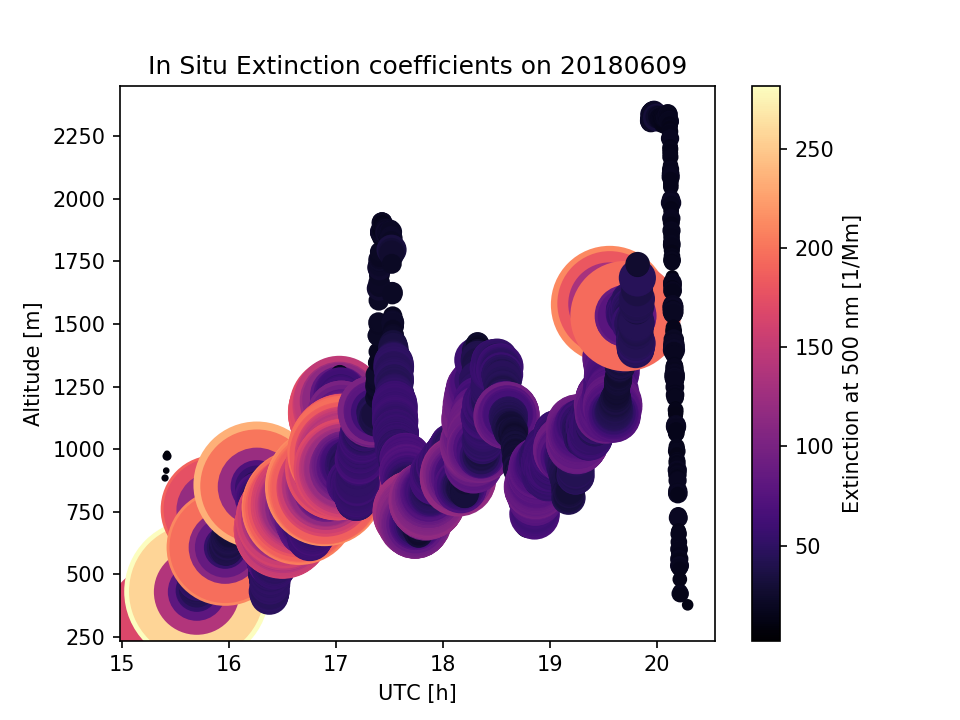

/home/sam/.local/lib/python2.7/site-packages/matplotlib/collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


In [88]:
plt.figure()
plt.scatter(insitu['utc'],insitu['alt'],c=insitu['extCalc500nm'],cmap=plt.cm.magma,s=(insitu['extCalc500nm'])**1.5-20.0)
cb = plt.colorbar()
cb.set_label('Extinction at 500 nm [1/Mm]')
plt.xlabel('UTC [h]')
plt.ylabel('Altitude [m]')
plt.title('In Situ Extinction coefficients on {}'.format(day))
plt.savefig(fp+'plots/Extinction_UTC_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

In [89]:
insitu['utc'].shape,insitu['alt'].shape,insitu['extCalc500nm'].shape

((19601,), (19601,), (19601,))

In [90]:
np.isfinite(insitu['extCalc500nm'])

array([False, False, False, ..., False, False, False])

In [119]:
dz_bin = 200.0 #in meters

In [91]:
binned_ext,binned_alt,binned_num = [],[],[]
for i in xrange(15):
    flaa = (insitu['alt'][infl]>=i*dz_bin) & (insitu['alt'][infl]<(i+1.0)*dz_bin) & (np.isfinite(insitu['extCalc500nm'][infl]))
    if flaa.any():
        binned_ext.append(insitu['extCalc500nm'][infl][flaa])
        binned_alt.append(np.mean([i*dz_bin,(i+1.0)*dz_bin]))
        binned_num.append(len(insitu['extCalc500nm'][infl][flaa]))

<IPython.core.display.Javascript object>


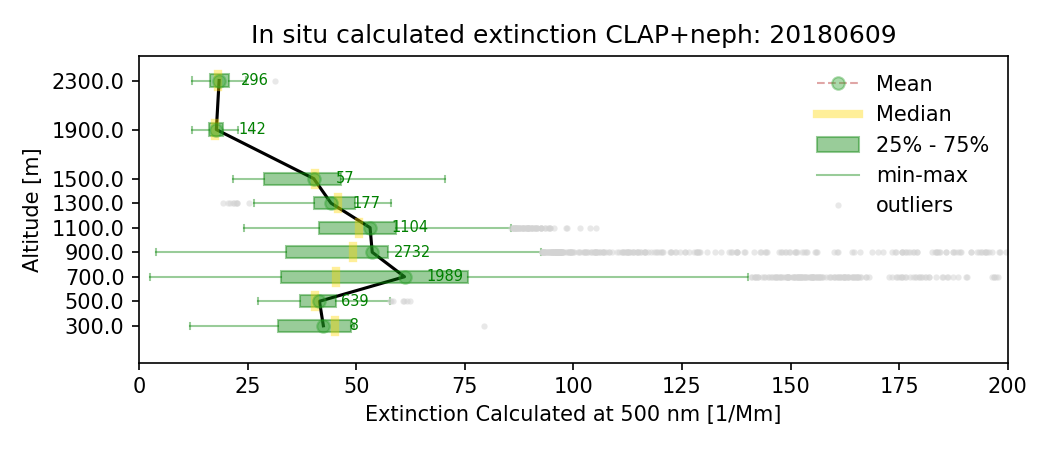

In [92]:
plt.figure(figsize=(7,3))
bp =plt.boxplot(binned_ext,positions=binned_alt,vert=False,showfliers=True,widths=100,showmeans=True,patch_artist=True)
plt.xlabel('Extinction Calculated at 500 nm [1/Mm]')
plt.ylabel('Altitude [m]')
#plt.plot(s['angs_470_865'][s['fl_QA_angs']],s['GPS_Alt'][s['fl_QA_angs']],'.',alpha=0.005)
for b in bp['boxes']:
    b.set_facecolor('green')
    b.set_edgecolor('green')
    b.set_alpha(0.4)
for b in bp['means']:
    b.set_marker('o')
    b.set_color('firebrick')
    b.set_alpha(0.4)
for b in bp['whiskers']:
    b.set_linestyle('-')
    b.set_color('green')
    b.set_alpha(0.4)
for b in bp['caps']:
    b.set_alpha(0.4)
    b.set_color('green')
for b in bp['medians']:
    b.set_linewidth(4)
    b.set_color('gold')
    b.set_alpha(0.4)
for b in bp['fliers']:
    b.set_marker('.')
    b.set_markeredgecolor('None')
    b.set_markerfacecolor('lightgrey')
    b.set_alpha(0.5)
ext_means = np.array([[b.get_data()[0][0],b.get_data()[1][0]] for b in bp['means']])
plt.plot(ext_means[:,0],ext_means[:,1],'-k',label='Means')
plt.xlim(0,200)
plt.ylim(0,2500)

for j,nn in enumerate(binned_num): 
    if nn>0:
        plt.text(min(bp['means'][j].get_data()[0])+5,binned_alt[j],'{:2.0f}'.format(nn),
                 color='g',fontsize=7,verticalalignment='center',horizontalalignment='left')


plt.legend([bp['means'][0],bp['medians'][0],bp['boxes'][0],bp['whiskers'][0],bp['fliers'][0]],
           ['Mean','Median','25% - 75%','min-max','outliers'],
           frameon=False,loc=1,numpoints=1)
plt.title('In situ calculated extinction CLAP+neph: {}'.format(day))
plt.tight_layout()
plt.savefig(fp+'plots/extinction_vertical_bins_clap_neph_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

In [223]:
ext_z = np.arange(binned_alt[0],binned_alt[-1]+2*dz_bin,dz_bin)/1000.0 # in km
fext_ = interp1d(ext_means[:,1]/1000.0,ext_means[:,0]/1000.0,fill_value=0.0,bounds_error=False)
ext_ = fext_(ext_z) # in 1/km

In [224]:
nz = len(ext_z)

In [225]:
ext_z

array([0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5])

In [226]:
ext_

array([0.04244464, 0.04154274, 0.06112582, 0.05368927, 0.05319572,
       0.0442154 , 0.04023183, 0.02902136, 0.01781089, 0.01812929,
       0.0184477 , 0.        ])

In [227]:
dz_km = ext_z[1]-ext_z[0]

In [228]:
dz_km = ext_z[1]-ext_z[0]
np.sum(ext_*dz_km)

0.08397092889958725

##  Calculate the extinction coefficient from 4STAR
Abandoned inquiry for now, did not seem feasible - no full column profile within center of plume

In [317]:
s['w'][0,405]

0.499079

In [ ]:
plt.scatter(insitu['utc'],insitu['alt'],c=insitu['extCalc500nm'],cmap=plt.cm.magma,s=(insitu['extCalc500nm'])**1.5-20.0)


In [341]:
s['Lat'][flag].shape,s['Alt'][flag].shape,s['tau_aero'][flag,405].shape

((6582, 1), (6582, 1), (6582,))

<IPython.core.display.Javascript object>


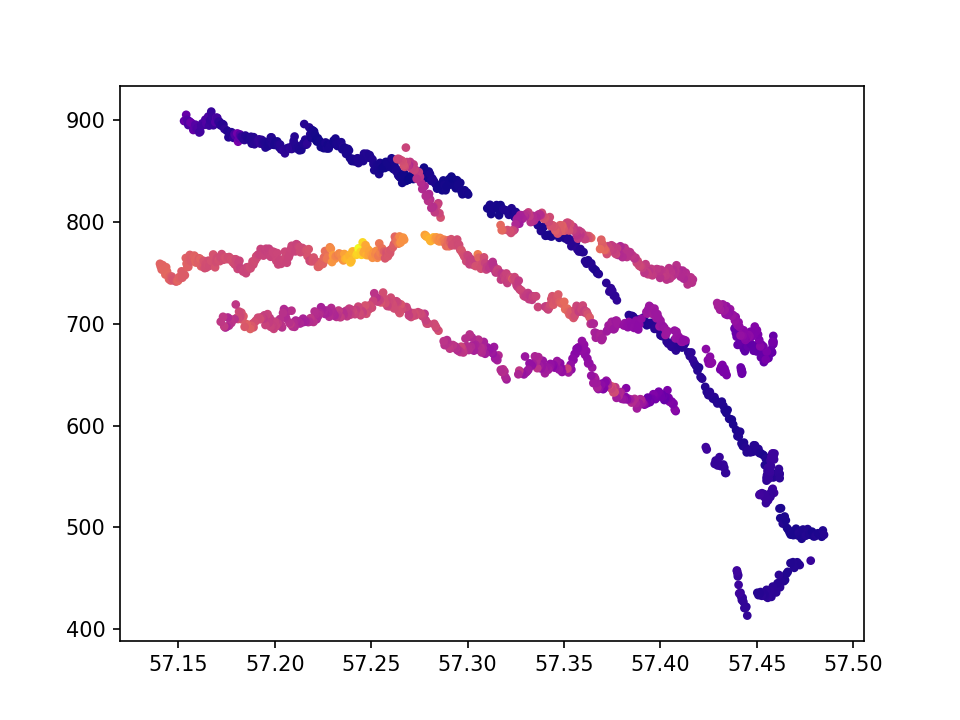

In [351]:
plt.figure()
plt.scatter(s['Lat'][fl_ea2][:,0],s['Alt'][fl_ea2][:,0],c=s['tau_aero'][fl_ea2,405][:],cmap=plt.cm.plasma,s=10)

<IPython.core.display.Javascript object>


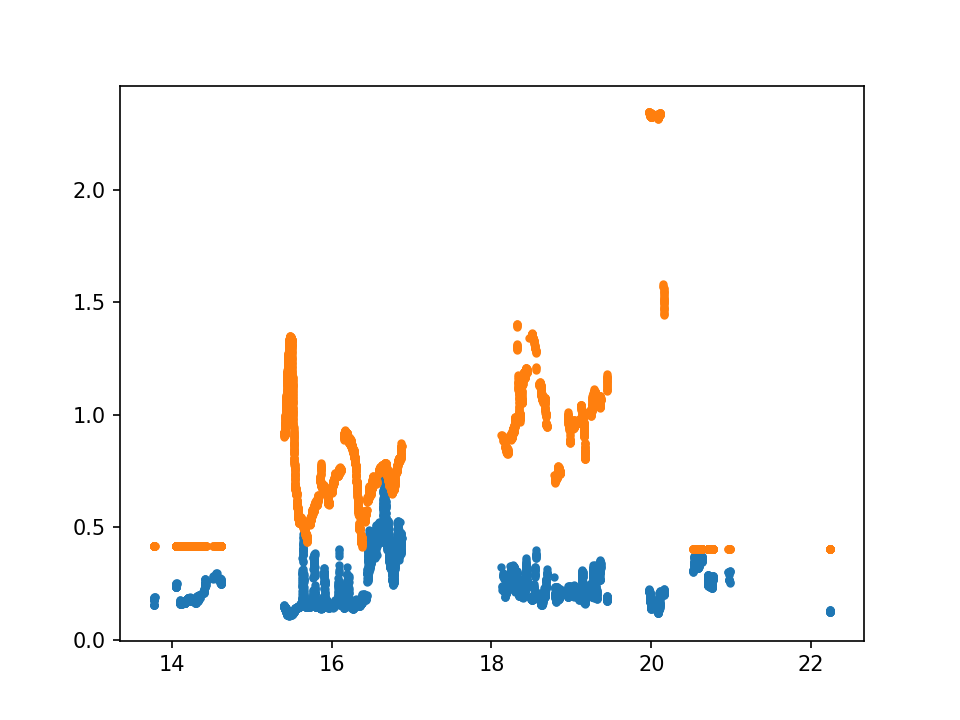

In [345]:
plt.figure()
plt.plot(s['utc'][flag],s['tau_aero'][flag,405],'.')
plt.plot(s['utc'][flag],s['Alt'][flag]/1000.0,'.')


<IPython.core.display.Javascript object>


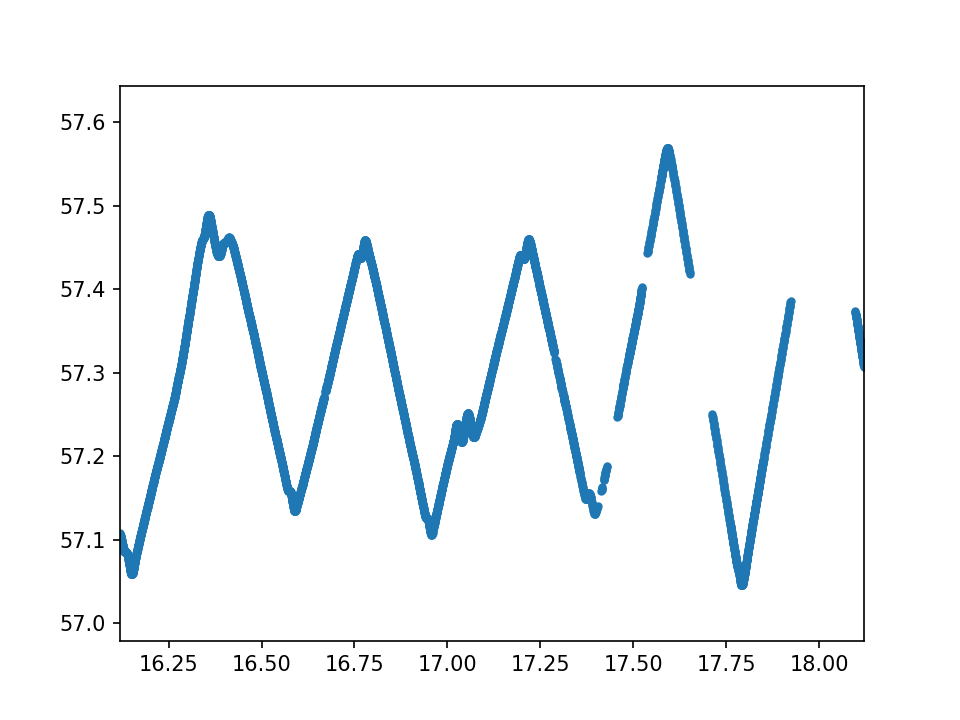

In [347]:
plt.figure()
plt.plot(s['utc'],s['Lat'],'.')

In [325]:
fl_ea = flag & (s['utc']>15.50) & (s['utc']<17.00)

In [350]:
fl_ea2 = flag & (s['utc']>16.2) & (s['utc']<18.00)

<IPython.core.display.Javascript object>


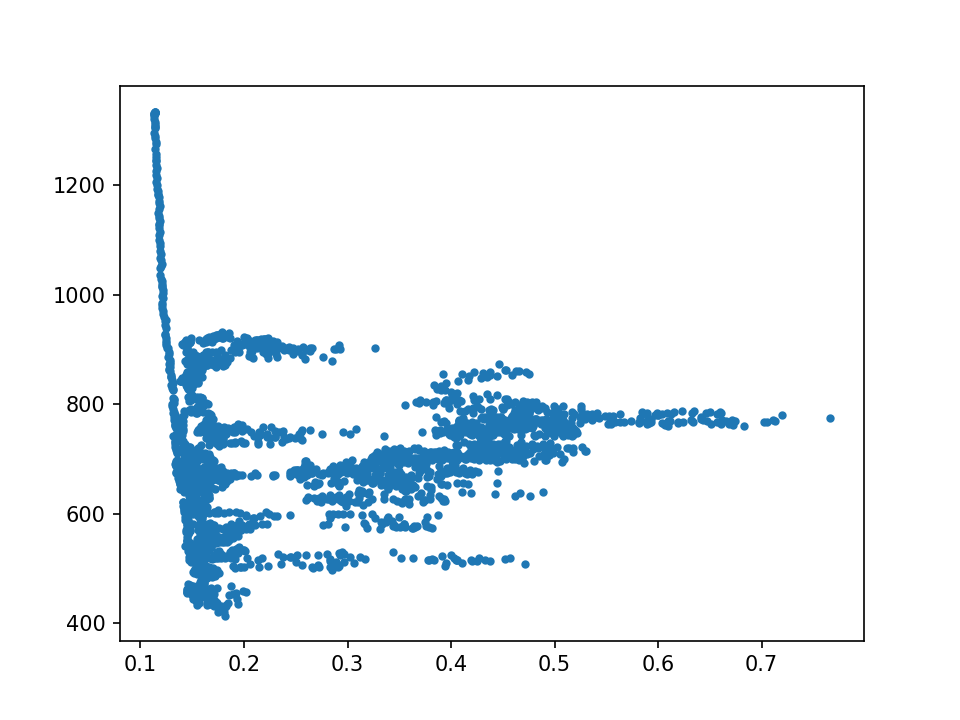

In [326]:
plt.figure()
plt.plot(s['tau_aero'][fl_ea,405],s['Alt'][fl_ea],'.')

# Now build the input files for DARE calculations


In [95]:
from write_utils import nearest_neighbor

In [229]:
geo = {'zout':[0,3,100],'year':int(day[0:4]),'month':int(day[4:6]),'day':int(day[6:8]),'hour':12,'minute':0,'second':0}
aero_base = {'z_arr':(ext_z+dz_km/2.0),'wvl_arr':wvl,'ssa':np.array([ssa,]*nz),'asy':np.array([asy,]*nz)}
source = {'integrate_values':True,'dat_path':fp_librad,
          'run_fuliou':True,'wvl_range':[350,4000]}
albedo = {'create_albedo_file':True,'alb':alb,'alb_wvl':wvl*1000.0}
cloud = {'dummy':None}

In [230]:
# Old way with no altitude filtering
if False:
    fx_ssa_insitu = interp1d(insitu['utc'],ssa_insitu,bounds_error=False)
    ssa_u = fx_ssa_insitu(s['utc'])
    ssa_u[ssa_u<0.8] = np.nan
else:
    ssa_u = nearest_neighbor(insitu['utc'],ssa_insitu,s['utc'],dist=1/3600.0)

In [232]:
def expand_ext_vert_and_spect(ext_,ext_z,aod_sp,alt,wvl):
    """
    create a 2d array of extintion (altitude, spectra). 
    Inputs:
        ext_: vertical profile of ext, 
        ext_z: altitudes of profile [km], 
        aod_sp: aod spectra, 
        alt: measured alt [km]
        wvl: wavelength array of the aod_sp [microns]
    """
    iz = np.argmin(abs(ext_z-alt))
    iw = np.argmin(abs(wvl-0.5))
    dz_km = ext_z[1]-ext_z[0]
    aod_ = np.sum(ext_[iz:]*dz_km)
    #aod_ = ext_[iz:].sum()/10.0
    
    factor = aod_sp[iw]/aod_
    exts = np.array([aod_sp/aod_sp[iw]*factor*e for e in ext_])
    return exts 

In [233]:
geo.pop('sza')

KeyError: 'sza'

## Write the input files

In [234]:
file_list = file(fp_rtm+'COSR_DARE_list_file_{d}_{v}.sh'.format(d=day,v=vv),'w')
file_list_clean = file(fp_rtm+'COSR_DARE_list_file_clean_{d}_{v}.sh'.format(d=day,v=vv),'w')
print 'Starting list file'
fpp_out = fp_rtm+'output/COSR_{d}_{v}/'.format(d=day,v=vv)
fpp_in = fp_rtm+'input/COSR_{d}_{v}/'.format(d=day,v=vv)
if not os.path.exists(fpp_out):
    os.mkdir(fpp_out)
if not os.path.exists(fpp_in):
    os.mkdir(fpp_in)

nu = len(s['utc'])
pbar = tqdm(total=nu)
for i,u in enumerate(s['utc']):
    aero = {}
    if flag[i] & np.isfinite(ssa_u[i]):
        aod = s['aod'][i,:]
        ext = expand_ext_vert_and_spect(ext_,ext_z,s['aod'][i,:],s['Alt'][i]/1000.0,wvl)
        iw = np.argmin(abs(aero_base['wvl_arr']-0.5))
        aero['ssa'] = aero_base['ssa']*ssa_u[i]/aero_base['ssa'][0,iw]
        aero['asy'] = aero_base['asy']
        aero['z_arr'] = aero_base['z_arr']
        aero['wvl_arr'] = aero_base['wvl_arr']*1000.0
        
        try: aero['ssa'][aero['ssa']<0.0] = 0.0
        except: pass
        try: aero['ssa'][aero['ssa']>1.0] = 1.0
        except: pass
        try: aero['asy'][aero['asy']<0.0] = 0.0
        except: pass
        try: aero['asy'][aero['asy']>1.0] = 1.0
        except: pass
        try: ext[ext<0.0] = 0.0
        except: pass
        
        #geo['sza'] = s['sza'][i]
        geo['lat'] = s['Lat'][i]
        geo['lon'] = s['Lon'][i]
        
        for ux in np.arange(0,24,0.5):
            geo['utc'] = ux
            geo['hour'] = int(ux)
            geo['minute'] = int((ux-int(ux))*60.0)
            geo['second'] = int((ux-geo['hour']-geo['minute']/60.0)*3600.0)

            aero['ext'] = ext
            fname = 'COSR_DARE_{d}_{v}_{i:06d}_{ux:04.1f}.dat'.format(d=day,v=vv,i=i,ux=ux)
            RL.write_input_aac(fpp_in+fname,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                                       verbose=False,make_base=False,set_quiet=True,solver='twostr')

            file_list.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+fname,out=fpp_out+fname))

            fnamec = 'COSR_DARE_{d}_{v}_{i:06d}_{ux:04.1f}_clean.dat'.format(d=day,v=vv,i=i,ux=ux)
            aero.pop('ext',None)
            RL.write_input_aac(fpp_in+fnamec,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                                       verbose=False,make_base=False,set_quiet=True,solver='twostr')

            file_list_clean.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+fnamec,out=fpp_out+fnamec))
    pbar.update(1)
    #print '{} / {}'.format(i,nu)
file_list.close()
file_list_clean.close()
print 'done'

Starting list file


A Jupyter Widget

done


## Run the files

In [235]:
fp_file_list = fp_rtm+'COSR_DARE_list_file_{d}_{v}.sh'.format(d=day,v=vv)
fp_file_list_clean = fp_rtm+'COSR_DARE_list_file_clean_{d}_{v}.sh'.format(d=day,v=vv)

In [236]:
! wc -l $fp_file_list
! wc -l $fp_file_list_clean

133776 /scratch/rtm/COSR_DARE_list_file_20180609_v3b.sh
133776 /scratch/rtm/COSR_DARE_list_file_clean_20180609_v3b.sh


In [237]:
fp_file_list_out = fp_file_list+'.out'
fp_file_list_clean_out = fp_file_list_clean+'.out'

In [238]:
!parallel --jobs=22 --bar --results /scratch/output_dir/out.csv < $fp_file_list  #2> $fp_file_list_out

100% 133776:0=0s /home/sam/libradtran/libRadtran-2.0.2b/bin/uvspec < /scratch/rtpnppppppppp.0.2b/bin/uvspec < /scratcppppppppppppppp2b/bin/uvspec < /scratnppppppppppppnppnpnppppppppppppp2b/bin/uvspec < /scratppppppppppnpppnppupuuuuuu/bin/uvspec < /scratchuuuuuuuuuuuuuuuuuuuuuuuuuuuupuuuuuuuuupuuuuuututtttttvspec < /scratch/rtmin/uvspec < /scratch/rtm/input


In [239]:
!parallel --jobs=22 --bar --results /scratch/output_dir/out_cl.csv < $fp_file_list_clean 

100% 133776:0=0s /home/sam/libradtran/libRadtran-2.0.2b/bin/uvspec < /scratch/rtpnppppppppppppnppnpppnpppppppppppppnppp2b/bin/uvspec < /scratppppp.2b/bin/uvspec < /scratppppppppnpppuuuuuupuuuuuuuuuuuuuuuuuuuuuuuuuuuupuuuuuuuuupuuuuuuuuuuuuuuuutbin/uvspec < /scratch/tttttut


## Now read the libradtran output files

In [240]:
out = {'ssa':[],'asy':[],'ext':[],'albedo':alb,'aod':[],'alt':[],
       'sza':[],'utc':[],'lat':[],'lon':[],'wvl':wvl,'z_aero':aero_base['z_arr']}

In [241]:
nzout = len(geo['zout'])

In [242]:
fl = flag & (np.isfinite(ssa_u))

In [243]:
nl = fl.sum()

In [244]:
nut = len(np.arange(0,24,0.5))

In [245]:
star_aero = {'dn':np.zeros((nl,nut,nzout))+np.nan,'up':np.zeros((nl,nut,nzout))+np.nan}
star_aero_cl = {'dn':np.zeros((nl,nut,nzout))+np.nan,'up':np.zeros((nl,nut,nzout))+np.nan}
star_aero_C = np.zeros((nl,nut,nzout))+np.nan
star_aero_C_avg = np.zeros((nl,nzout))+np.nan

In [164]:
import pixiedust

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table USER_PREFERENCES created successfully
Table service_connections created successfully


In [246]:
#%%pixie_debugger
nu = len(s['utc'])
pbar = tqdm(total=nu)
out['utcx'] = np.arange(0,24,0.5)
print 'Reading files'
j = 0
for i,u in enumerate(s['utc']):
    aero = {}
    if flag[i] & np.isfinite(ssa_u[i]):
        aod = s['aod'][i,:]
        aero['ext'] = expand_ext_vert_and_spect(ext_,ext_z,s['aod'][i,:],s['Alt'][i]/1000.0,wvl)
        iw = np.argmin(abs(aero_base['wvl_arr']-0.5))
        aero['ssa'] = aero_base['ssa']*ssa_u[i]/aero_base['ssa'][0,iw]
        aero['asy'] = aero_base['asy']
        aero['z_arr'] = aero_base['z_arr']
        aero['wvl_arr'] = aero_base['wvl_arr']*1000.0
        
        try: aero['ssa'][aero['ssa']<0.0] = 0.0
        except: pass
        try: aero['ssa'][aero['ssa']>1.0] = 1.0
        except: pass
        try: aero['asy'][aero['asy']<0.0] = 0.0
        except: pass
        try: aero['asy'][aero['asy']>1.0] = 1.0
        except: pass
        try: aero['ext'][aero['ext']<0.0] = 0.0
        except: pass
        
        out['utc'].append(u)
        out['sza'].append(s['sza'][i])
        out['lat'].append(s['Lat'][i])
        out['lon'].append(s['Lon'][i])
        out['alt'].append(s['Alt'][i])
        out['ext'].append(aero['ext'])
        out['ssa'].append(aero['ssa'])
        out['asy'].append(aero['asy'])
        out['aod'].append(aod)
        
        
        for ui, ux in enumerate(np.arange(0,24,0.5)):
        
            try:
                fname = 'COSR_DARE_{d}_{v}_{i:06d}_{ux:04.1f}.dat'.format(d=day,v=vv,i=i,ux=ux)
                sa = RL.read_libradtran(fpp_out+fname,zout=geo['zout'])
                star_aero['dn'][j,ui,:] = sa['diffuse_down']+sa['direct_down']
                star_aero['up'][j,ui,:] = sa['diffuse_up']
         
                fnamec = 'COSR_DARE_{d}_{v}_{i:06d}_{ux:04.1f}_clean.dat'.format(d=day,v=vv,i=i,ux=ux)
                sc = RL.read_libradtran(fpp_out+fnamec,zout=geo['zout'])
                star_aero_cl['dn'][j,ui,:] = sc['diffuse_down']+sc['direct_down']
                star_aero_cl['up'][j,ui,:] = sc['diffuse_up']
            except IOError:
                star_aero['dn'][j,ui,:] = np.nan
                star_aero['up'][j,ui,:] = np.nan
                star_aero_cl['dn'][j,ui,:] = np.nan
                star_aero_cl['up'][j,ui,:] = np.nan
                pass
            
            star_aero_C[j,ui,:] = (star_aero['dn'][j,ui,:]-star_aero['up'][j,ui,:]) - \
                                (star_aero_cl['dn'][j,ui,:]-star_aero_cl['up'][j,ui,:])
        star_aero_C_avg[j,:] = np.nanmean(star_aero_C[j,:,:],axis=0)
        
        j = j +1
    pbar.update(1)

out['utc'] = np.array(out['utc'])
out['sza'] = np.array(out['sza'])
out['lat'] = np.array(out['lat'])
out['lon'] = np.array(out['lon'])
out['alt'] = np.array(out['alt'])
out['ext'] = np.array(out['ext'])
out['ssa'] = np.array(out['ssa'])
out['asy'] = np.array(out['asy'])
out['aod'] = np.array(out['aod'])
out['dare'] = star_aero_C
out['dare_avg'] = star_aero_C_avg
out['dn_aero'] = star_aero['dn']
out['up_aero'] = star_aero['up']
out['dn_clear'] = star_aero_cl['dn']
out['up_clear'] = star_aero_cl['up']

print 'done'

A Jupyter Widget

Reading files
done


## Filter for bad data

### For too high data

In [326]:
itoohigh = (out['alt'] >= ext_z[-3]*1000.0)[:,0]

In [327]:
itoohigh

array([False, False, False, ...,  True,  True,  True])

In [328]:
out['dare'][itoohigh,:,:] = np.nan
out['dare_avg'][itoohigh,:] = np.nan

### For zeros

In [247]:
out['dare_avg'][out['dare_avg']==0] = np.nan

## Save DARE to file

In [333]:
#star = wu.iterate_dict_unicode(out)
out['zout'] = geo['zout']
print 'saving file to: '+fp+'{name}_DARE_{d}_{vv}.mat'.format(name=name,d=day,vv=vv)
hs.savemat(fp+'{name}_DARE_{d}_{vv}.mat'.format(name=name,d=day,vv=vv),out)

saving file to: /data/sam/COSR/COSR_DARE_20180609_v3b.mat


/home/sam/.local/lib/python2.7/site-packages/hdf5storage/__init__.py:1234: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(filename)


# Now plot out the DARE for this flight

In [249]:
out['dare'].shape

(2787, 48, 3)

In [250]:
out['aod'][:-1,3].shape

(2786,)

In [251]:
out['dare_avg'].shape

(2787, 3)

## Plot selection of input/output variables

<IPython.core.display.Javascript object>


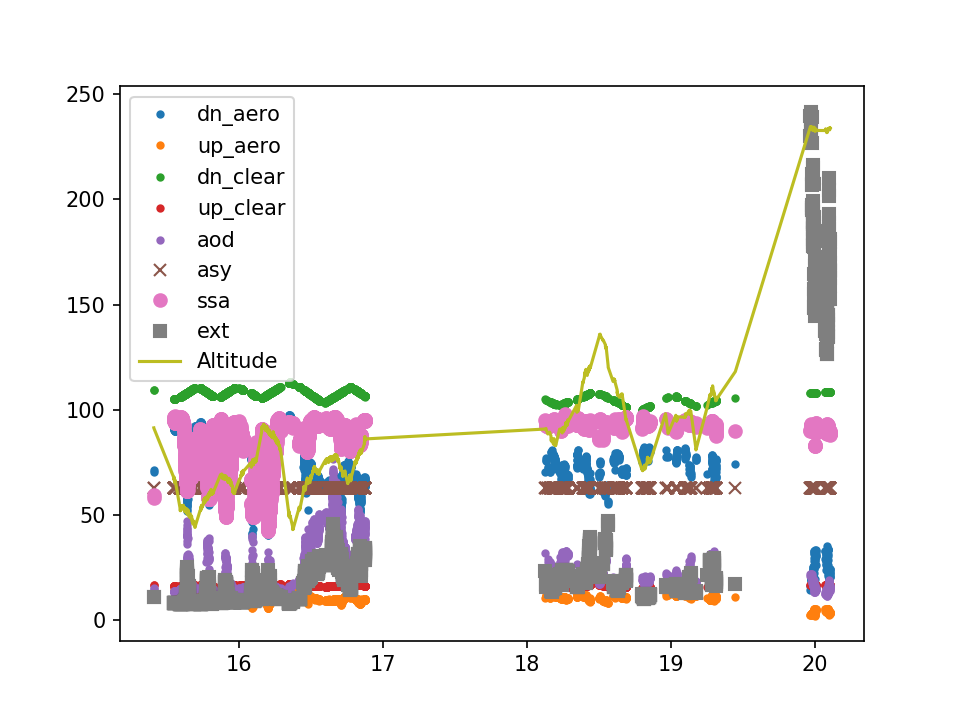

In [334]:
plt.figure()
plt.plot(out['utc'],out['dn_aero'][:,24,0],'.',label='dn_aero')
plt.plot(out['utc'],out['up_aero'][:,24,0],'.',label='up_aero')
plt.plot(out['utc'],out['dn_clear'][:,24,0],'.',label='dn_clear')
plt.plot(out['utc'],out['up_clear'][:,24,0],'.',label='up_clear')
plt.plot(out['utc'],out['aod'][:,3]*100.0,'.',label='aod')
plt.plot(out['utc'],out['asy'][:,6,3]*100.0,'x',label='asy')
plt.plot(out['utc'],out['ssa'][:,6,3]*100.0,'o',label='ssa')
plt.plot(out['utc'],out['ext'][:,6,3]*100,'s',label='ext')
plt.plot(out['utc'],out['alt']/10.0,'-',label='Altitude')
leg = plt.legend()
leg.draggable()

<IPython.core.display.Javascript object>


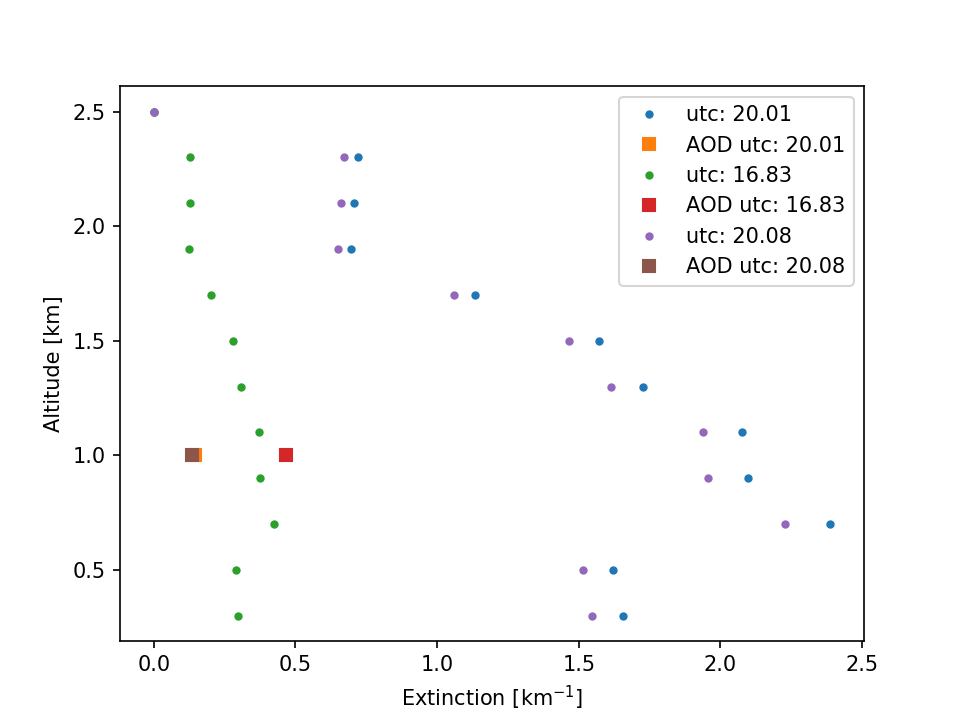

Text(0,0.5,'Altitude [km]')

In [304]:
plt.figure()

plt.plot(out['ext'][2730,:,3],ext_z,'.',label='utc: {:2.2f}'.format(out['utc'][2730]))
plt.plot(out['aod'][2730,3],[1.0],'s',label='AOD utc: {:2.2f}'.format(out['utc'][2730]))
plt.plot(out['ext'][2050,:,3],ext_z,'.',label='utc: {:2.2f}'.format(out['utc'][2050]))
plt.plot(out['aod'][2050,3],[1.0],'s',label='AOD utc: {:2.2f}'.format(out['utc'][2050]))
plt.plot(out['ext'][2750,:,3],ext_z,'.',label='utc: {:2.2f}'.format(out['utc'][2750]))
plt.plot(out['aod'][2750,3],[1.0],'s',label='AOD utc: {:2.2f}'.format(out['utc'][2750]))

plt.legend()
plt.xlabel('Extinction [km$^{{-1}}$]')
plt.ylabel('Altitude [km]')

## Plots the DARE

<IPython.core.display.Javascript object>


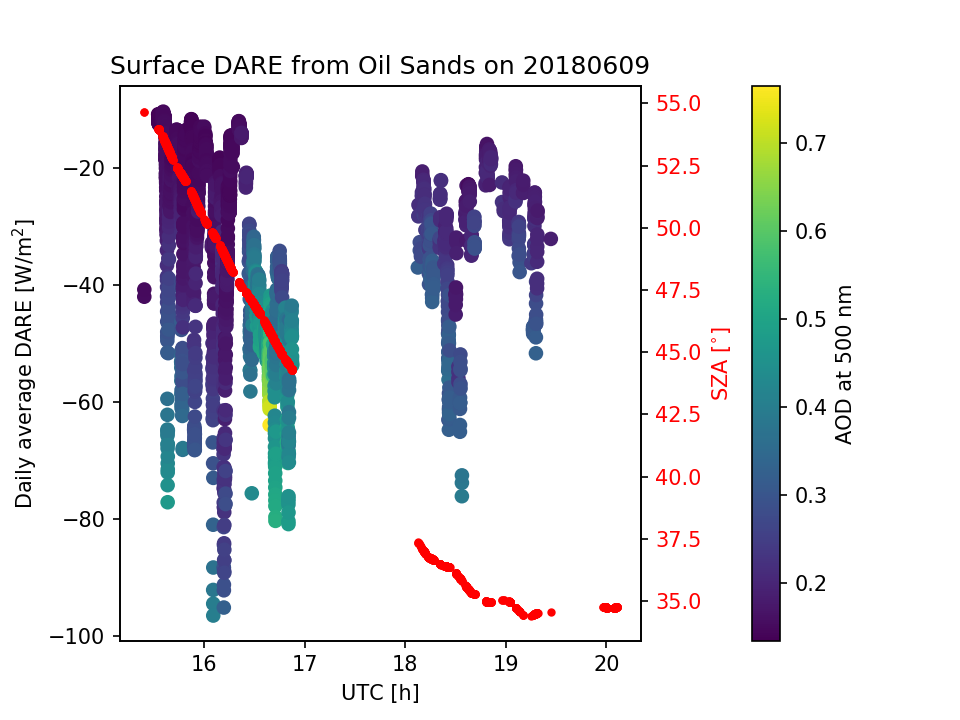

In [335]:
plt.figure()
plt.scatter(out['utc'][:],out['dare_avg'][:,0],c=out['aod'][:,3])
plt.xlabel('UTC [h]')
plt.ylabel('Daily average DARE [W/m$^2$]')
ax2 = plt.gca().twinx()
ax2.plot(out['utc'],out['sza'],'.r')
ax2.set_ylabel('SZA [$^{{\\circ}}$]',color='r')
ax2.tick_params(axis='y', labelcolor='r')
cb = plt.colorbar( pad=0.15)
cb.set_label('AOD at 500 nm')

plt.title('Surface DARE from Oil Sands on {}'.format(day))
plt.savefig(fp+'plots/DARE_avg_aod_utc_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


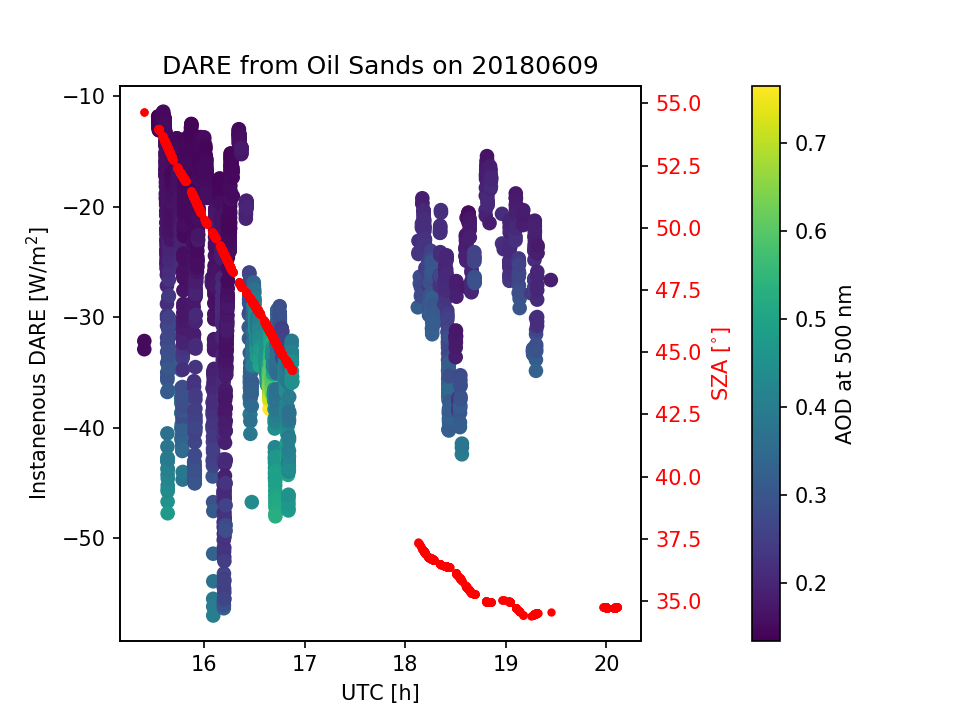

In [332]:
plt.figure()
plt.scatter(out['utc'][:],out['dare'][:,24,0],c=out['aod'][:,3])
plt.xlabel('UTC [h]')
plt.ylabel('Instanenous DARE [W/m$^2$]')
ax2 = plt.gca().twinx()
ax2.plot(out['utc'],out['sza'],'.r')
ax2.set_ylabel('SZA [$^{{\\circ}}$]',color='r')
ax2.tick_params(axis='y', labelcolor='r')
cb = plt.colorbar( pad=0.15)
cb.set_label('AOD at 500 nm')

plt.title('DARE from Oil Sands on {}'.format(day))
plt.savefig(fp+'plots/DARE_aod_utc_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


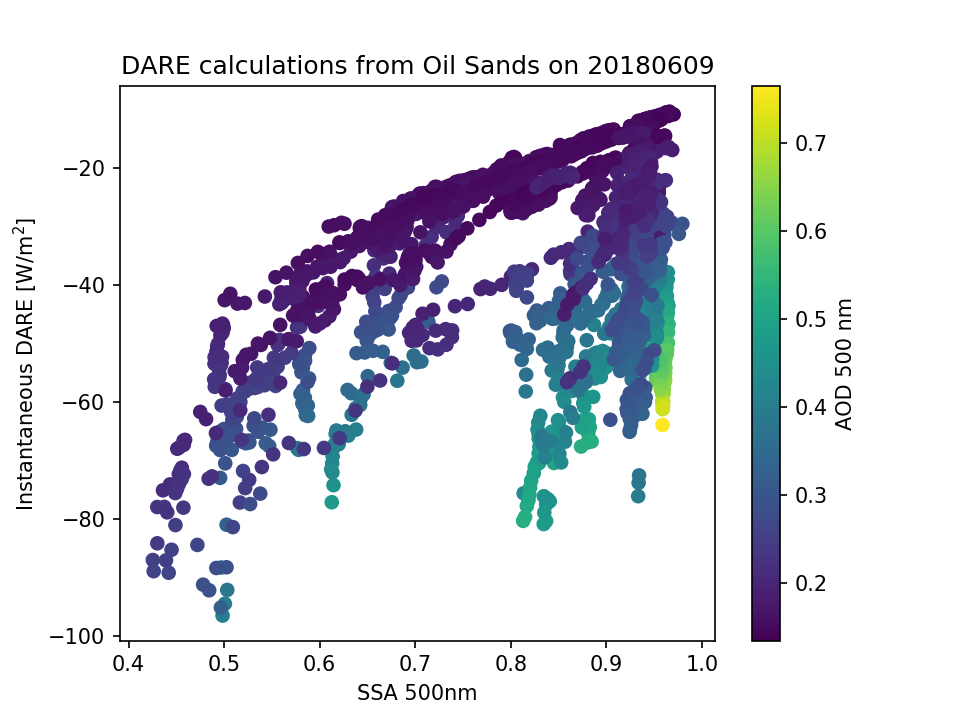

In [336]:
plt.figure()
plt.scatter(out['ssa'][:,0,3],out['dare_avg'][:,0],c=out['aod'][:,3])
cb = plt.colorbar()
cb.set_label('AOD 500 nm')
plt.xlabel('SSA 500nm')
plt.ylabel('Instantaneous DARE [W/m$^2$]')
plt.title('DARE calculations from Oil Sands on {}'.format(day))

plt.savefig(fp+'plots/DARE_24havg_vs_SSA_{}_{}.png'.format(vv,day),dpi=600,transparent=True)

## Plot compared to UHSAS

In [337]:
fx_h = interp1d(uh['utc'],uh['nConc'],bounds_error=False)
nConc = fx_h(out['utc'])

<IPython.core.display.Javascript object>


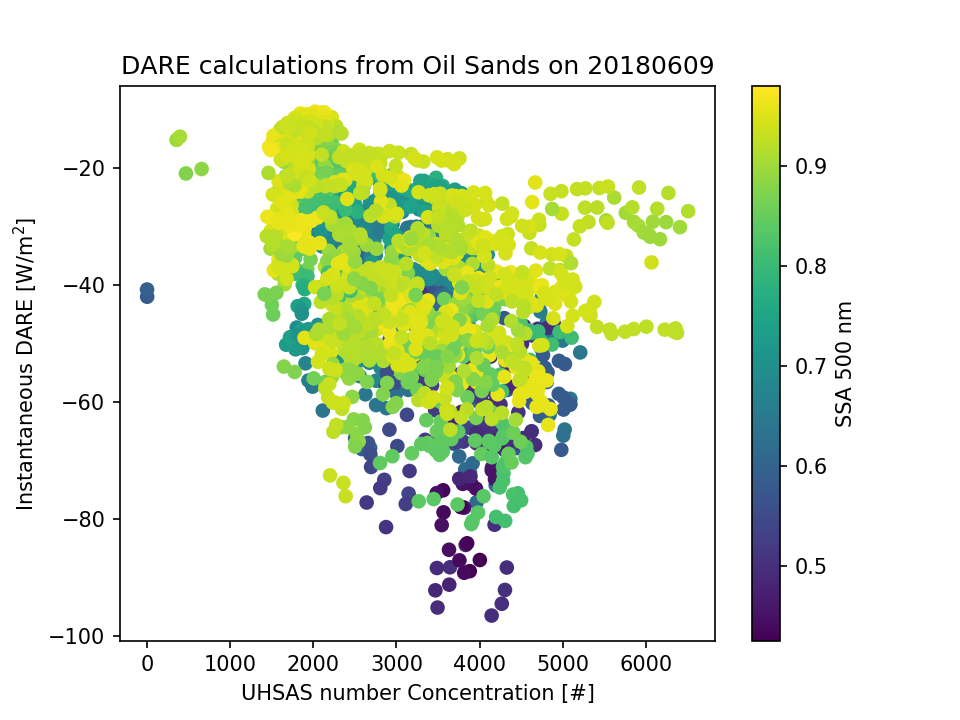

In [338]:
plt.figure()
plt.scatter(nConc,out['dare_avg'][:,0],c=out['ssa'][:,0,3])
cb = plt.colorbar()
cb.set_label('SSA 500 nm')
plt.xlabel('UHSAS number Concentration [#]')
plt.ylabel('Instantaneous DARE [W/m$^2$]')
plt.title('DARE calculations from Oil Sands on {}'.format(day))
plt.savefig(fp+'plots/DARE_vs_nConc_UHSAS_{}.png'.format(day),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


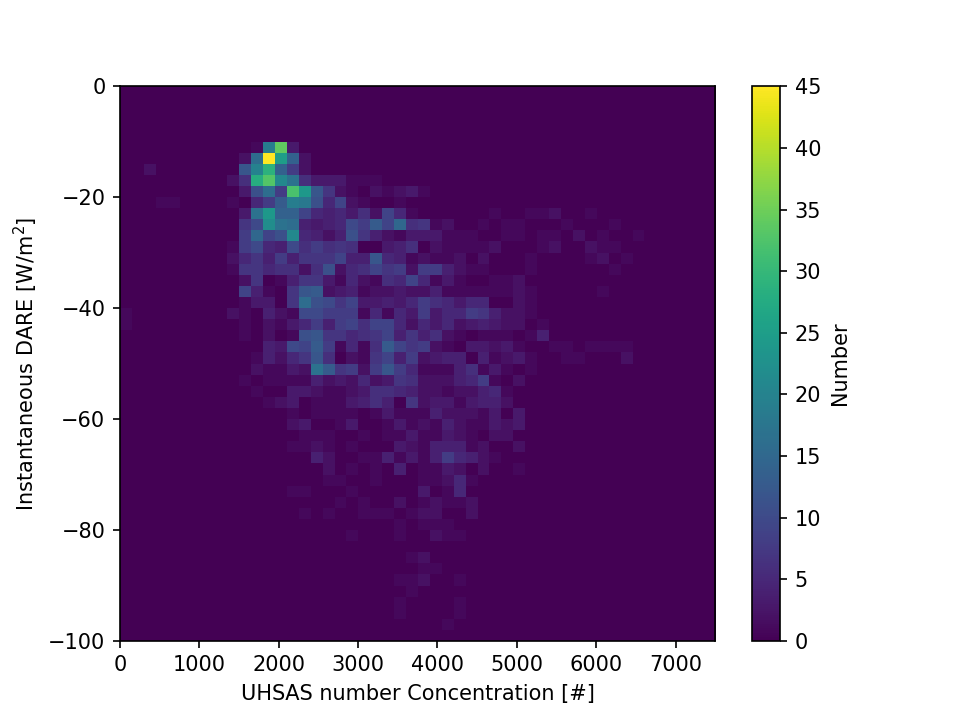

Text(0,0.5,'Instantaneous DARE [W/m$^2$]')

In [339]:
plt.figure()
plt.hist2d(nConc,out['dare_avg'][:,0],range=[[0,7500],[-100,0]],bins=50)
plt.colorbar(label='Number')
plt.xlabel('UHSAS number Concentration [#]')
plt.ylabel('Instantaneous DARE [W/m$^2$]')

## Plot filtered for in plume

In [341]:
out = out1

In [342]:
ipl = []
dare_pl = []
alt_pl = []
dare_out = []
alt_out = []
for ii, fo in enumerate(from_utc):
    pl = (out['utc']>=fo)&(out['utc']<=to_utc[ii])
    if pl.any():
        alt_pl = np.append(alt_pl,out['alt'][pl])
        dare_pl = np.append(dare_pl,out['dare_avg'][pl,0])
        ipl.append(pl)
    dare_out = np.append(dare_out,out['dare_avg'][~pl,0])
    alt_out = np.append(alt_out,out['alt'][~pl,0])

<IPython.core.display.Javascript object>


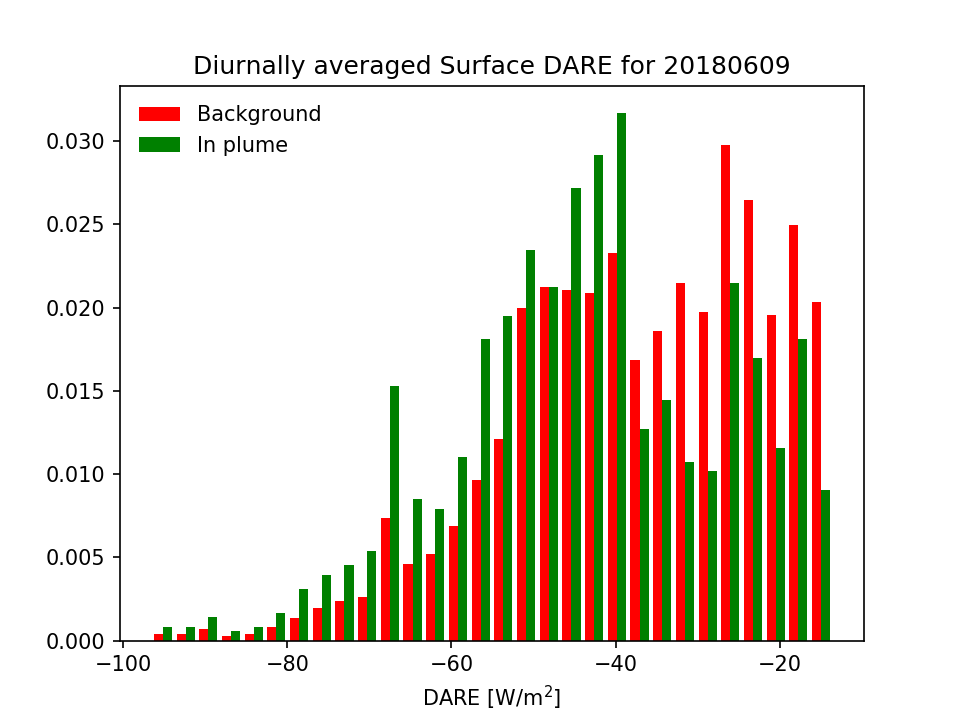

/home/sam/.local/lib/python2.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sam/.local/lib/python2.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5,1,'Diurnally averaged Surface DARE for 20180609')

In [343]:
plt.figure()
plt.hist([dare_out,dare_pl],color=['r','g'],label=['Background','In plume'],normed=True,bins=30)
plt.legend(frameon=False)
plt.xlabel('DARE [W/m$^2$]')
plt.title('Diurnally averaged Surface DARE for {}'.format(day))

In [344]:
ssa_u[1235]

nan

In [311]:
np.where(flag&np.isfinite(ssa_u))[0][367]

4941

In [312]:
out['ext'][367,:,3]

array([0.09205196, 0.09009595, 0.13256683, 0.11643878, 0.1153684 ,
       0.0958923 , 0.08725292, 0.06294017, 0.03862743, 0.03931797,
       0.04000851, 0.        ])

In [313]:
out['z_aero']

array([0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6])

In [693]:
out['ext'][367,:,3].sum()

0.2378972807710264

In [695]:
out['aod'][367,3]

0.1488338839171186

In [725]:
i = 4105

In [726]:
ext = expand_ext_vert_and_spect(ext_,ext_z,s['aod'][i,:],s['Alt'][i]/1000.0,wvl)

In [727]:
ext.shape

(15, 13)

In [728]:
ext[:,3].sum()

0.43545562042236396

In [729]:
s['aod'][i,3]

0.11441751994069706

In [705]:
out1['daystr'] = '20180609'
out2['daystr'] = '20180618'
out3['daystr'] = '20180624'
out4['daystr'] = '20180625'

<IPython.core.display.Javascript object>


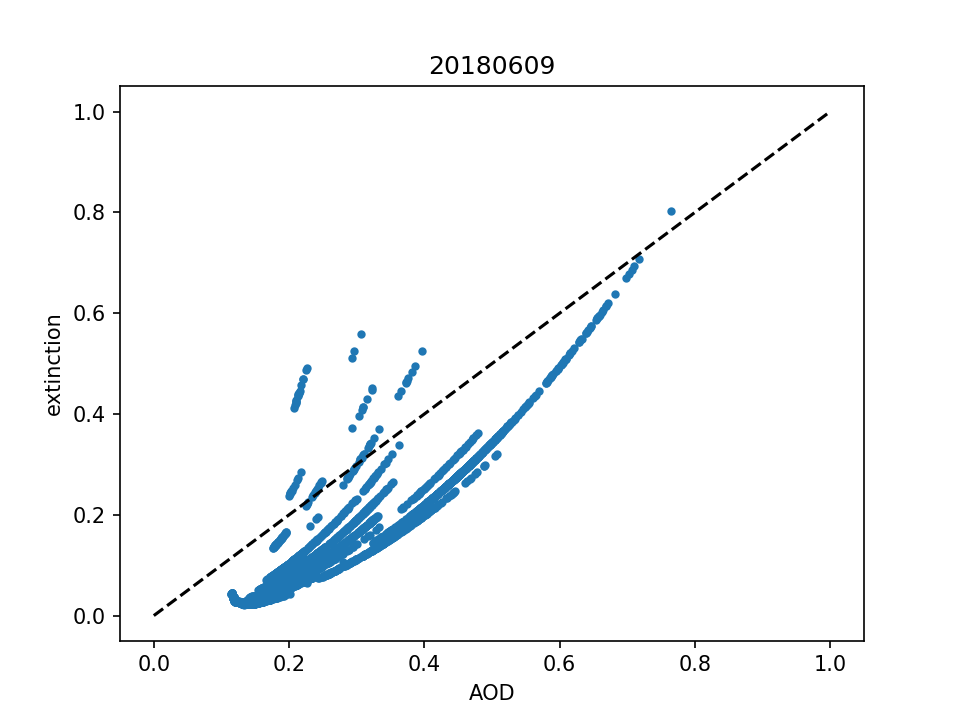

<IPython.core.display.Javascript object>


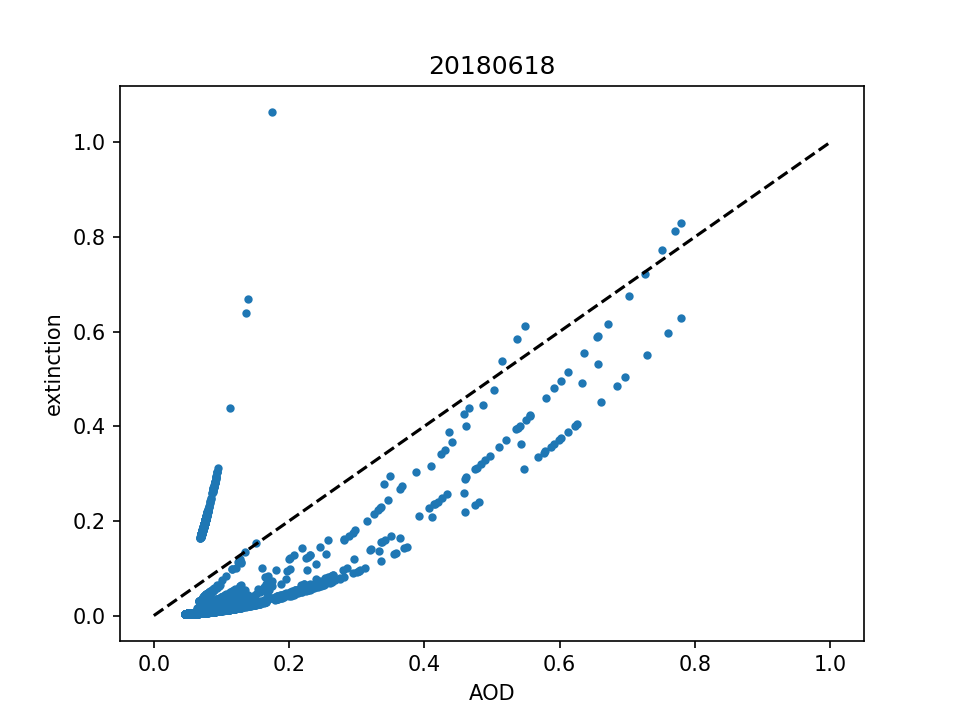

<IPython.core.display.Javascript object>


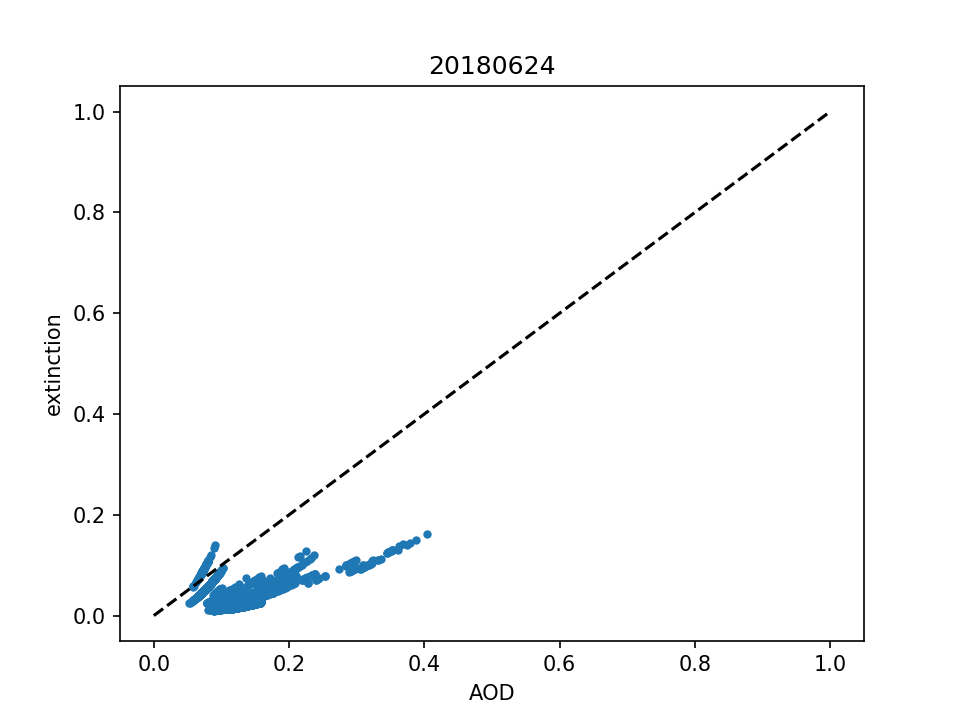

<IPython.core.display.Javascript object>


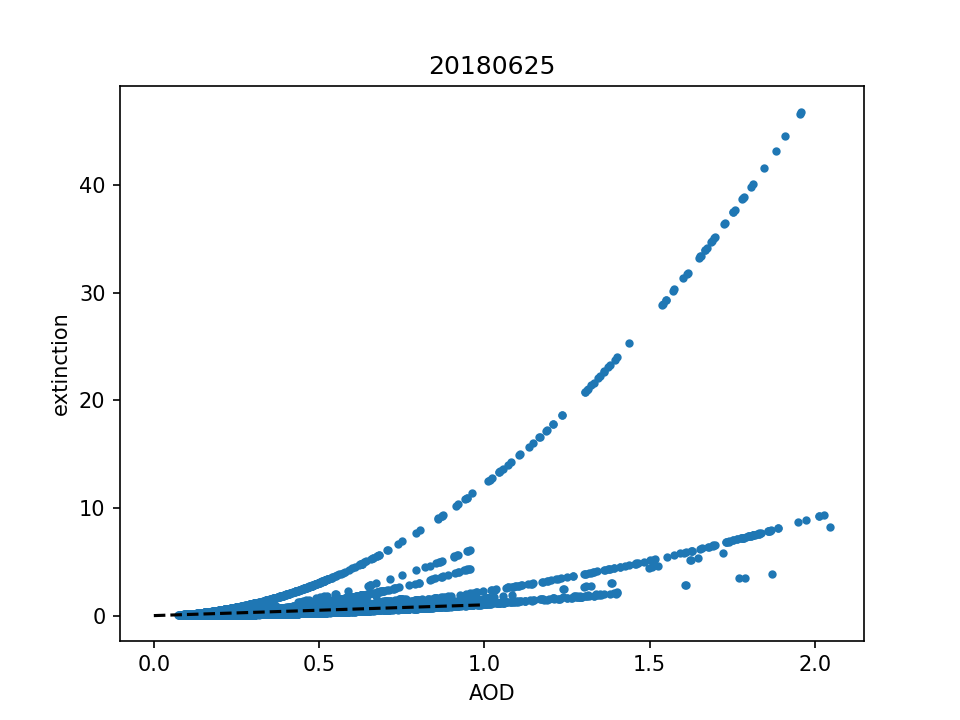

In [706]:
for outi in [out1,out2,out3,out4]:
    plt.figure()
    plt.plot(outi['aod'][:,3],outi['ext'][:,:,3].sum(axis=1)/10.0,'.')
    plt.plot([0,1],[0,1],'--k')
    plt.xlabel('AOD')
    plt.ylabel('extinction')
    plt.title('{}'.format(outi['daystr']))

<IPython.core.display.Javascript object>


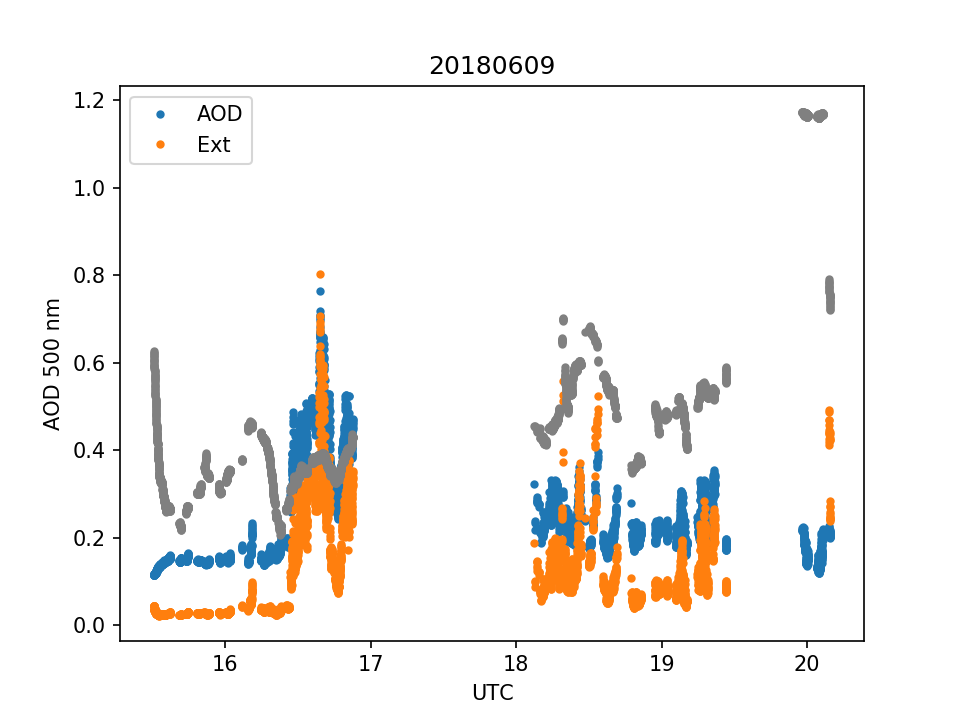

<IPython.core.display.Javascript object>


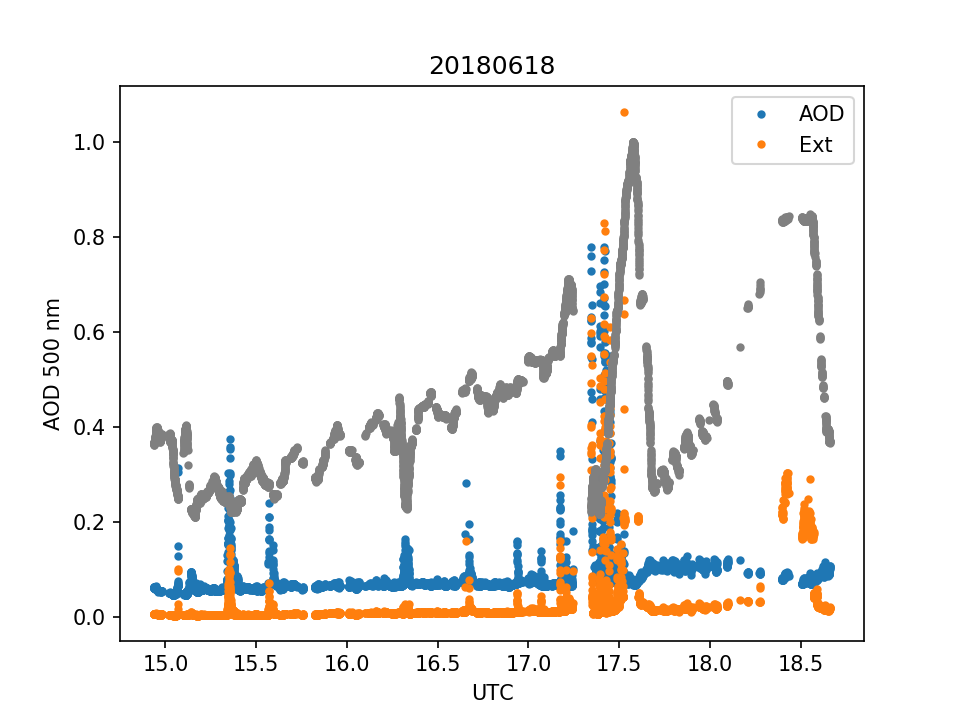

<IPython.core.display.Javascript object>


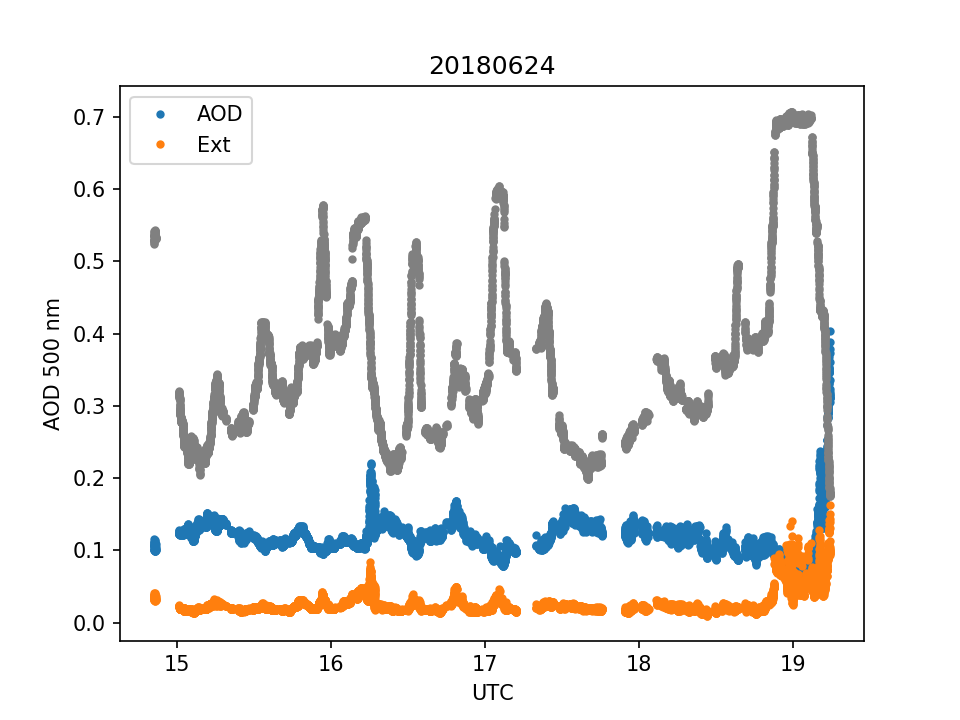

<IPython.core.display.Javascript object>


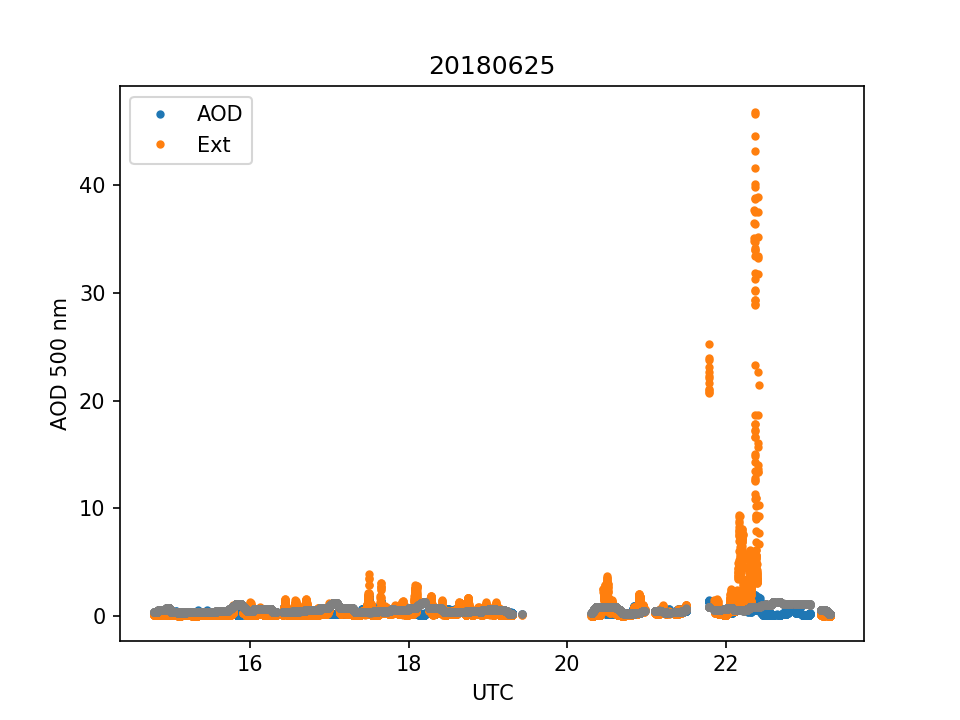

In [733]:
for outi in [out1,out2,out3,out4]:
    plt.figure()
    plt.plot(outi['utc'],outi['aod'][:,3],'.',label='AOD')
    plt.plot(outi['utc'],outi['ext'][:,:,3].sum(axis=1)/10.0,'.',label='Ext')
    plt.plot(outi['utc'],outi['alt']/2000.0,'.',color='grey')
    #plt.plot([0,1],[0,1],'--k')
    plt.xlabel('UTC')
    plt.ylabel('AOD 500 nm')
    plt.legend()
    plt.title('{}'.format(outi['daystr']))

## Plot filtered for level legs

In [811]:
nbox = 30

In [812]:
std_alt1 = running_std(out1['alt'],nbox)

<IPython.core.display.Javascript object>


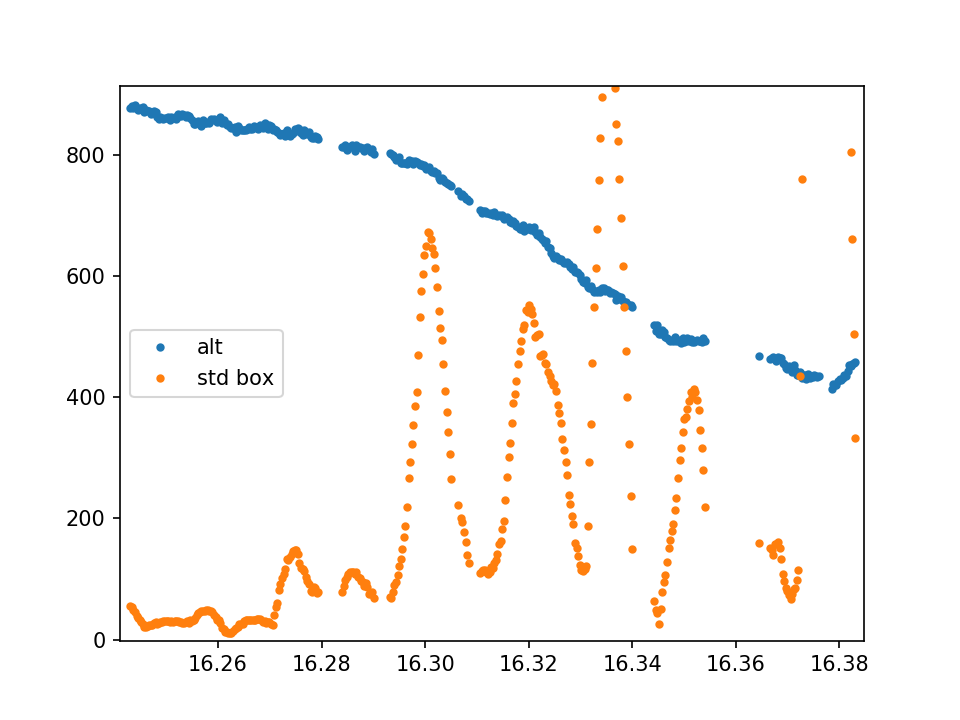

In [813]:
plt.figure()
plt.plot(out1['utc'],out1['alt'],'.',label='alt')
plt.plot(out1['utc'][:1-nbox],std_alt1,'.',label='std box')
plt.legend()

In [816]:
falt = np.where(std_alt1<100.0)[0]

<IPython.core.display.Javascript object>


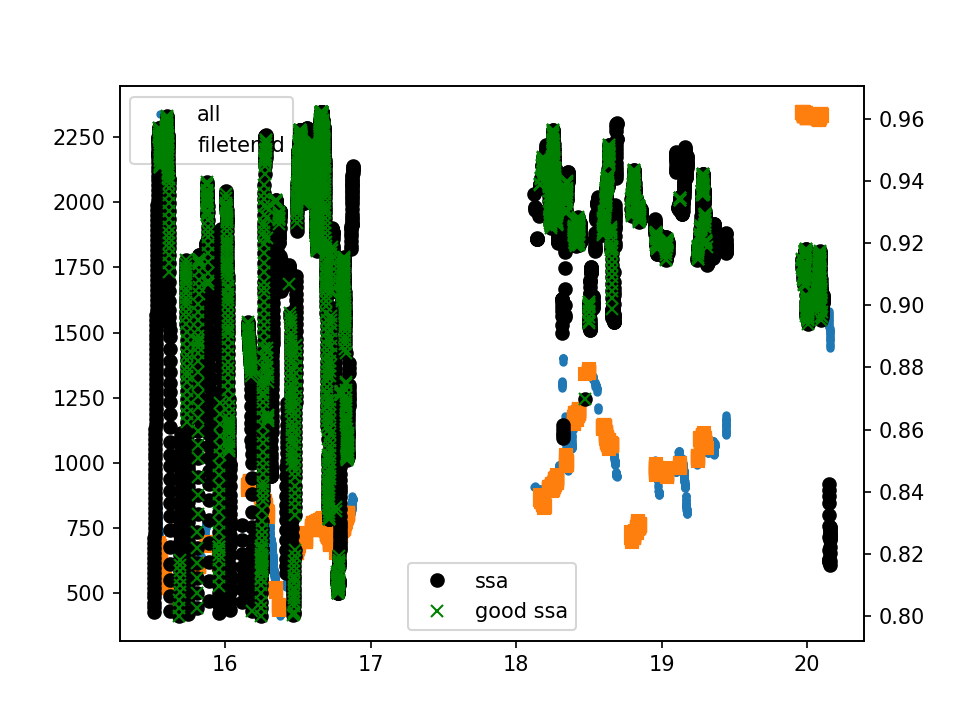

In [827]:
fig, ax1 = plt.subplots()

ax1.plot(out1['utc'],out1['alt'],'.',label='all')
ax1.plot(out1['utc'][falt],out1['alt'][falt],'s',label='filetered')
plt.legend()

ax2 = ax1.twinx()
ax2.plot(out1['utc'],out1['ssa'][:,7,3],'ok',label='ssa')
ax2.plot(out1['utc'][falt],out1['ssa'][falt,7,3],'xg',label='good ssa')
plt.legend()

In [819]:
out1.keys()

[u'dn_aero',
 u'aod',
 u'dn_clear',
 u'up_clear',
 u'utc',
 u'z_aero',
 u'asy',
 u'sza',
 u'lon',
 u'ext',
 u'dare_avg',
 u'zout',
 u'dare',
 u'wvl',
 u'lat',
 'daystr',
 u'utcx',
 u'albedo',
 u'ssa',
 u'alt',
 u'up_aero']

In [820]:
out1['ssa'].shape

(4255, 15, 13)

In [823]:
out1['z_aero'].shape

(15,)

# Combine the DARE calc for all days

In [345]:
day = '20180609'
#day = '20180618'
#day = '20180624'
#day = '20180625'

In [349]:
out1 = hs.loadmat(fp+'{name}_DARE_{d}_{vv}.mat'.format(name=name,d='20180609',vv=vv))

In [347]:
out2 = hs.loadmat(fp+'{name}_DARE_{d}_{vv}.mat'.format(name=name,d='20180618',vv=vv))

IOError: Unable to open file (unable to open file: name = '/data/sam/COSR/COSR_DARE_20180618_v3b.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [348]:
out3 = hs.loadmat(fp+'{name}_DARE_{d}_{vv}.mat'.format(name=name,d='20180624',vv=vv))

IOError: Unable to open file (unable to open file: name = '/data/sam/COSR/COSR_DARE_20180624_v3b.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [374]:
out4 = hs.loadmat(fp+'{name}_DARE_{d}_{vv}.mat'.format(name=name,d='20180625',vv=vv))

## Get the time tables 

### 20180609

In [350]:
flttable1 = pd.read_excel(fp+'flt_table/fltable_{}.xlsx'.format('20180609'))
fromtime1 = flttable['FromTime'][flttable['FlightType']=='in plume']
totime1 = flttable['ToTime'][flttable['FlightType']=='in plume']
plumeid1 = flttable['PlumeId'][(flttable['PlumeId']=='A') | (flttable['PlumeId']=='B')].to_numpy()

In [351]:
def time_utc(x):
    return np.array([y.hour+y.minute/60.0+y.second/3600.0 for y in x])

In [352]:
from_utc1 = time_utc(fromtime1.to_numpy())
to_utc1 = time_utc(totime1.to_numpy())

In [353]:
ipl1 = []
dare_pl1,dare_pl1a,dare_pl1b = [],[],[]
alt_pl1 = []
dare_out1 = []
alt_out1 = []
dare_pl1_toa,dare_pl1a_toa,dare_pl1b_toa, dare_out1_toa  = [],[],[],[]
for ii, fo in enumerate(from_utc1):
    pl1 = (out1['utc']>=fo)&(out1['utc']<=to_utc1[ii])
    if pl1.any():
        alt_pl1 = np.append(alt_pl1,out1['alt'][pl1])
        dare_pl1 = np.append(dare_pl1,out1['dare_avg'][pl1,0])
        dare_pl1_toa = np.append(dare_pl1_toa,out1['dare_avg'][pl1,2])
        if plumeid1[ii]=='A':
            dare_pl1a = np.append(dare_pl1a,out1['dare_avg'][pl1,0])
            dare_pl1a_toa = np.append(dare_pl1a_toa,out1['dare_avg'][pl1,2])
        else:
            dare_pl1b = np.append(dare_pl1b,out1['dare_avg'][pl1,0])
            dare_pl1b_toa = np.append(dare_pl1b_toa,out1['dare_avg'][pl1,2])
        ipl1.append(pl1)
    dare_out1 = np.append(dare_out1,out1['dare_avg'][~pl1,0])
    dare_out1_toa = np.append(dare_out1_toa,out1['dare_avg'][~pl1,2])
    alt_out1 = np.append(alt_out1,out1['alt'][~pl1,0])

In [354]:
out1.keys()

[u'dn_aero',
 u'aod',
 u'dn_clear',
 u'up_clear',
 u'utc',
 u'z_aero',
 u'asy',
 u'sza',
 u'lon',
 u'ext',
 u'dare_avg',
 u'zout',
 u'dare',
 u'wvl',
 u'lat',
 u'utcx',
 u'albedo',
 u'ssa',
 u'alt',
 u'up_aero']

In [355]:
ppl1 = np.array(ipl1).flatten()

<IPython.core.display.Javascript object>


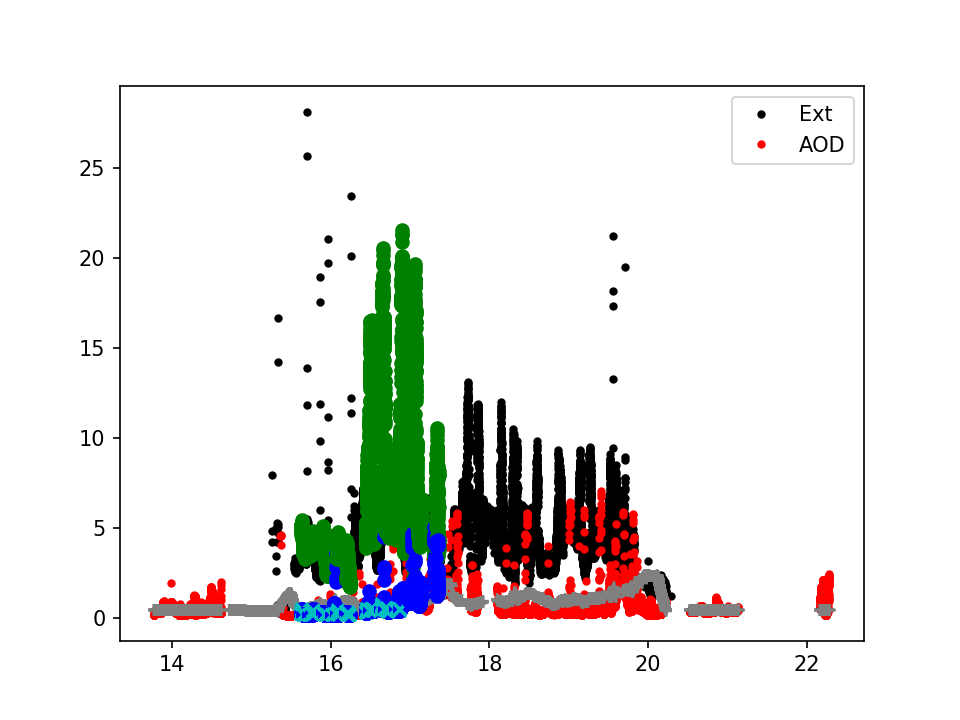

In [356]:
# Plot out the input extinction and aod
plt.figure()
plt.plot(insitu['utc'],insitu['extCalc500nm']/10.0,'.k',label='Ext')
plt.plot(s['utc'],s['tau_aero'][:,400],'.r',label='AOD')
plt.plot(s['utc'],s['Alt']/1000.0,'+',color='grey')
plt.legend()
for ii, fo in enumerate(from_utc1):
    plsitu = (insitu['utc']>=fo)&(insitu['utc']<=to_utc1[ii])
    if plsitu.any():
        plt.plot(insitu['utc'][plsitu],insitu['extCalc500nm'][plsitu]/10.0,'og')
    plaod = (s['utc']>=fo)&(s['utc']<=to_utc1[ii])
    if plaod.any():
        plt.plot(s['utc'][plaod],s['tau_aero'][plaod,400],'ob')
    
    plaodf = (s['utc'][flag]>=fo)&(s['utc'][flag]<=to_utc1[ii])
    if plaod.any():
        plt.plot(s['utc'][flag][plaodf],s['tau_aero'][flag,400][plaodf],'xc')
    
    
        

In [1009]:
insitu['extCalc500nm'] = np.array(insitu['extCalc500nm'])

<IPython.core.display.Javascript object>


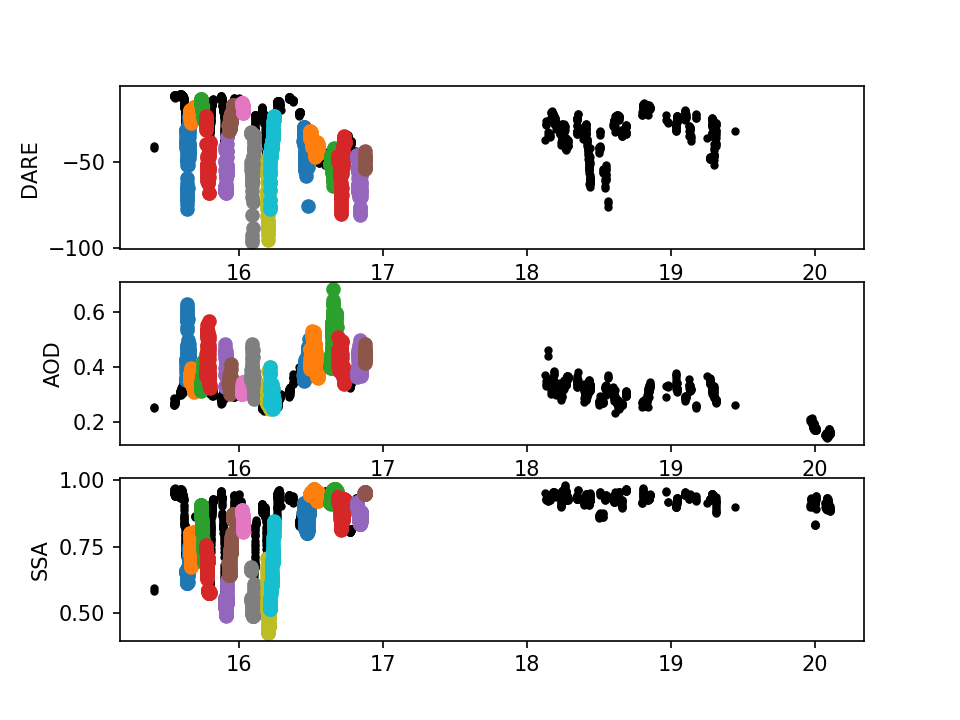

Text(0,0.5,'SSA')

In [357]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(out1['utc'],out1['dare_avg'][:,0],'.k',label='all')
for ipp in ipl1:
    ax1.plot(out1['utc'][ipp],out1['dare_avg'][ipp,0],'o')
ax1.set_ylabel('DARE')
    
ax2 = fig.add_subplot(312,sharex = ax1)
ax2.plot(out1['utc'],out1['aod'][:,0],'.k',label='all')
for ipp in ipl1:
    ax2.plot(out1['utc'][ipp],out1['aod'][ipp,0],'o')
ax2.set_ylabel('AOD')
    
ax3 = fig.add_subplot(313,sharex = ax1)
ax3.plot(out1['utc'],out1['ssa'][:,2,3],'.k',label='all')
for ipp in ipl1:
    ax3.plot(out1['utc'][ipp],out1['ssa'][ipp,2,3],'o')
ax3.set_ylabel('SSA')

In [358]:
out1['ext'].shape

(2787, 12, 13)

In [389]:
avgs1 = {'bmea':np.nanmean(dare_out1),'bmed':np.nanmedian(dare_out1),'bstd':np.nanstd(dare_out1),
         'pamea':np.nanmean(dare_pl1a),'pamed':np.nanmedian(dare_pl1a),'pastd':np.nanstd(dare_pl1a),
         'pbmea':np.nanmean(dare_pl1b),'pbmed':np.nanmedian(dare_pl1b),'pbstd':np.nanstd(dare_pl1b)}

<IPython.core.display.Javascript object>


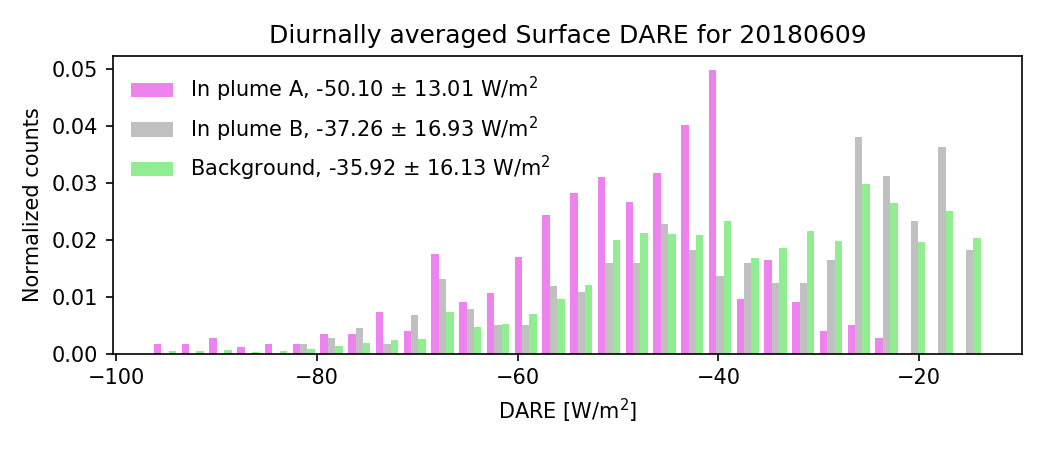

In [387]:
plt.figure(figsize=(7,3))
plt.hist([dare_pl1a,dare_pl1b,dare_out1],color=['violet','silver','lightgreen'],
         label=['In plume A, {pamea:2.2f} $\\pm$ {pastd:2.2f} W/m$^2$'.format(**avgs1),
                'In plume B, {pbmea:2.2f} $\\pm$ {pbstd:2.2f} W/m$^2$'.format(**avgs1),
                'Background, {bmea:2.2f} $\\pm$ {bstd:2.2f} W/m$^2$'.format(**avgs1)],
         normed=True,bins=30)

plt.legend(frameon=False)
plt.xlabel('DARE [W/m$^2$]')
plt.ylabel('Normalized counts')
plt.title('Diurnally averaged Surface DARE for {}'.format(day))
plt.tight_layout()
plt.savefig(fp+'plots/DARE_hist_surface_background_inplume_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

In [390]:
avgs1_toa = {'bmea':np.nanmean(dare_out1_toa),'bmed':np.nanmedian(dare_out1_toa),'bstd':np.nanstd(dare_out1_toa),
         'pamea':np.nanmean(dare_pl1a_toa),'pamed':np.nanmedian(dare_pl1a_toa),'pastd':np.nanstd(dare_pl1a_toa),
         'pbmea':np.nanmean(dare_pl1b_toa),'pbmed':np.nanmedian(dare_pl1b_toa),'pbstd':np.nanstd(dare_pl1b_toa)}

<IPython.core.display.Javascript object>


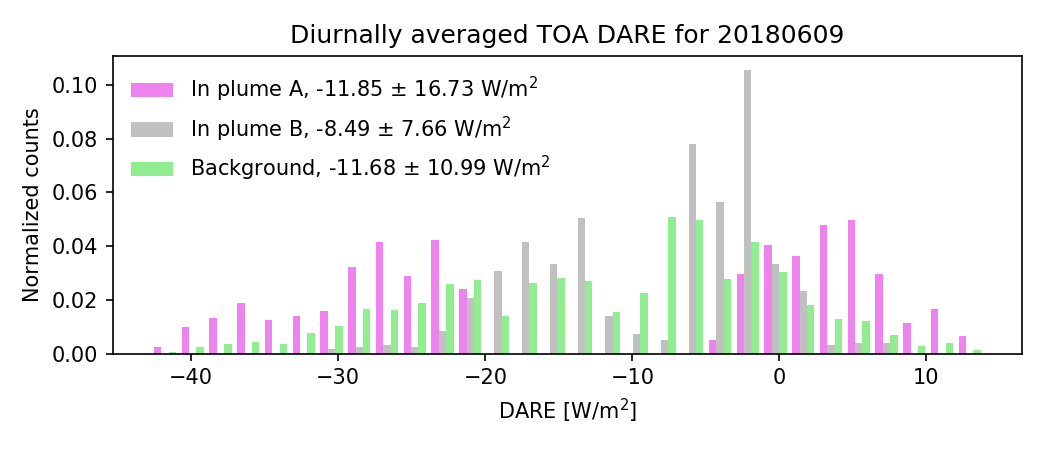

In [391]:
plt.figure(figsize=(7,3))
plt.hist([dare_pl1a_toa,dare_pl1b_toa,dare_out1_toa],color=['violet','silver','lightgreen'],
         label=['In plume A, {pamea:2.2f} $\\pm$ {pastd:2.2f} W/m$^2$'.format(**avgs1_toa),
                'In plume B, {pbmea:2.2f} $\\pm$ {pbstd:2.2f} W/m$^2$'.format(**avgs1_toa),
                'Background, {bmea:2.2f} $\\pm$ {bstd:2.2f} W/m$^2$'.format(**avgs1_toa)],
         normed=True,bins=30)

plt.legend(frameon=False)
plt.xlabel('DARE [W/m$^2$]')
plt.ylabel('Normalized counts')
plt.title('Diurnally averaged TOA DARE for {}'.format(day))
plt.tight_layout()
plt.savefig(fp+'plots/DARE_hist_TOA_background_inplume_{}_{}.png'.format(day,vv),dpi=600,transparent=True)

### 20180618

In [200]:
flttable2 = pd.read_excel(fp+'flt_table/fltable_{}.xlsx'.format('20180618'))
fromtime2 = flttable2['FromTime'][flttable2['FlightType']=='in plume']
totime2 = flttable2['ToTime'][flttable2['FlightType']=='in plume']

In [209]:
plumeid2 = flttable2['PlumeId'][(flttable2['PlumeId']=='A') | (flttable2['PlumeId']=='B')].to_numpy()

In [201]:
flttable2

YYYY   MM    DD  flNumNRC  flNumECCC   FlightType PlumeId Facility  \
0       NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
1       NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
2       NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
3       NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
4       NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
5    2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
6    2018.0  6.0  18.0      33.0       19.0    spiral up     NaN        A   
7    2018.0  6.0  18.0      33.0       19.0  spiral down     NaN        A   
8    2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
9    2018.0  6.0  18.0      33.0       19.0     in plume       A        A   
10   2018.0  6.0  18.0      33.0       19.0     in plume       B        A   
11   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
12      NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
13   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
14   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
15   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
16   2018.0  6.0  18.0      33.0       19.0     in plume       A        A   
17   2018.0  6.0  18.0      33.0       19.0     in plume       B        A   
18   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
19   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
20      NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
21   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
22   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
23   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
24   2018.0  6.0  18.0      33.0       19.0     in plume       A        A   
25   2018.0  6.0  18.0      33.0       19.0     in plume       B        A   
26   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
27   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
28      NaN  NaN   NaN       NaN        NaN          NaN     NaN      NaN   
29   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        A   
..      ...  ...   ...       ...        ...          ...     ...      ...   
92   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
93   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
94   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
95   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
96   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
97   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
98   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
99   2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
100  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
101  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
102  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
103  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
104  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
105  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
106  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
107  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
108  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
109  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
110  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
111  2018.0  6.0  18.0      33.0       19.0    emissions     NaN        B   
112

In [202]:
from_utc2 = time_utc(fromtime2.to_numpy())
to_utc2 = time_utc(totime2.to_numpy())

In [210]:
ipl2 = []
dare_pl2 = []
dare_pl2a,dare_pl2b = [], []
alt_pl2 = []
dare_out2 = []
alt_out2 = []
dare_pl2_toa,dare_pl2a_toa,dare_pl2b_toa, dare_out2_toa  = [],[],[],[]
for ii, fo in enumerate(from_utc2):
    pl2 = (out2['utc']>=fo)&(out2['utc']<=to_utc2[ii])
    if pl2.any():
        alt_pl2 = np.append(alt_pl2,out2['alt'][pl2])
        dare_pl2 = np.append(dare_pl2,out2['dare_avg'][pl2[:],0])
        dare_pl2_toa = np.append(dare_pl2_toa,out2['dare_avg'][pl2[:],2])
        if plumeid2[ii]=='A':
            dare_pl2a = np.append(dare_pl2a,out2['dare_avg'][pl2,0])
            dare_pl2a_toa = np.append(dare_pl2a_toa,out2['dare_avg'][pl2,2])
        else:
            dare_pl2b = np.append(dare_pl2b,out2['dare_avg'][pl2,0])
            dare_pl2b_toa = np.append(dare_pl2b_toa,out2['dare_avg'][pl2,2])
        ipl2.append(pl2)
    dare_out2 = np.append(dare_out2,out2['dare_avg'][~pl2[:],0])
    dare_out2_toa = np.append(dare_out2_toa,out2['dare_avg'][~pl2[:],2])
    alt_out2 = np.append(alt_out2,out2['alt'][~pl2,0])

<IPython.core.display.Javascript object>


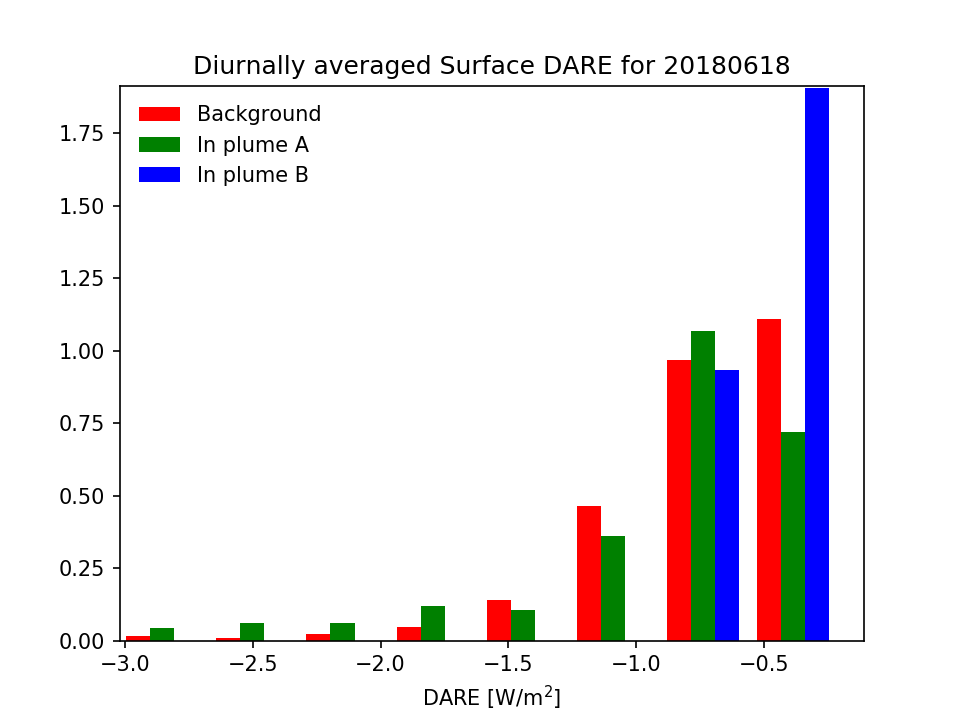

/home/sam/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/sam/.local/lib/python2.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sam/.local/lib/python2.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5,1,'Diurnally averaged Surface DARE for 20180618')

In [211]:
plt.figure()
plt.hist([dare_out2,dare_pl2a,dare_pl2b],color=['r','g','b'],label=['Background','In plume A','In plume B'],
         normed=True,bins=30)
plt.legend(frameon=False)
plt.xlabel('DARE [W/m$^2$]')
plt.title('Diurnally averaged Surface DARE for {}'.format(day))

### 20180624

In [387]:
flttable3 = pd.read_excel(fp+'flt_table/fltable_{}.xlsx'.format('20180624'))
fromtime3 = flttable3['FromTime'][flttable3['FlightType']=='in plume']
totime3 = flttable3['ToTime'][flttable3['FlightType']=='in plume']

In [388]:
from_utc3 = time_utc(fromtime3.to_numpy())
to_utc3 = time_utc(totime3.to_numpy())

In [418]:
ipl3 = []
dare_pl3 = []
alt_pl3 = []
dare_out3 = []
alt_out3 = []
dare_pl3_toa, dare_out3_toa  = [],[]
for ii, fo in enumerate(from_utc3):
    pl3 = (out3['utc']>=fo)&(out3['utc']<=to_utc3[ii])
    if pl3.any():
        alt_pl3 = np.append(alt_pl3,out3['alt'][pl3])
        dare_pl3 = np.append(dare_pl3,out3['dare_avg'][pl3,0])
        dare_pl3_toa = np.append(dare_pl3_toa,out3['dare_avg'][pl3,2])
        ipl3.append(pl3)
    dare_out3 = np.append(dare_out3,out3['dare_avg'][~pl3,0])
    dare_out3_toa = np.append(dare_out3_toa,out3['dare_avg'][~pl3,0])
    alt_out3 = np.append(alt_out3,out3['alt'][~pl3,0])

### 20180625

In [391]:
flttable4 = pd.read_excel(fp+'flt_table/fltable_{}.xlsx'.format('20180625'))
fromtime4 = flttable4['FromTime'][flttable4['FlightType']=='in plume']
totime4 = flttable4['ToTime'][flttable4['FlightType']=='in plume']

In [392]:
from_utc4 = time_utc(fromtime4.to_numpy())
to_utc4 = time_utc(totime4.to_numpy())

In [419]:
ipl4 = []
dare_pl4 = []
alt_pl4 = []
dare_out4 = []
alt_out4 = []
dare_pl4_toa, dare_out4_toa  = [],[]
for ii, fo in enumerate(from_utc4):
    pl4 = (out4['utc']>=fo)&(out4['utc']<=to_utc4[ii])
    if pl4.any():
        alt_pl4 = np.append(alt_pl4,out4['alt'][pl4])
        dare_pl4 = np.append(dare_pl4,out4['dare_avg'][pl4,0])
        dare_pl4_toa = np.append(dare_pl4_toa,out4['dare_avg'][pl4,0])
        ipl4.append(pl4)
    dare_out4 = np.append(dare_out4,out4['dare_avg'][~pl4,0])
    dare_out4_toa = np.append(dare_out4_toa,out4['dare_avg'][~pl4,0])
    alt_out4 = np.append(alt_out4,out4['alt'][~pl4,0])

## Plot the DAREs

In [412]:
fp

u'/data/sam/COSR/'

<IPython.core.display.Javascript object>


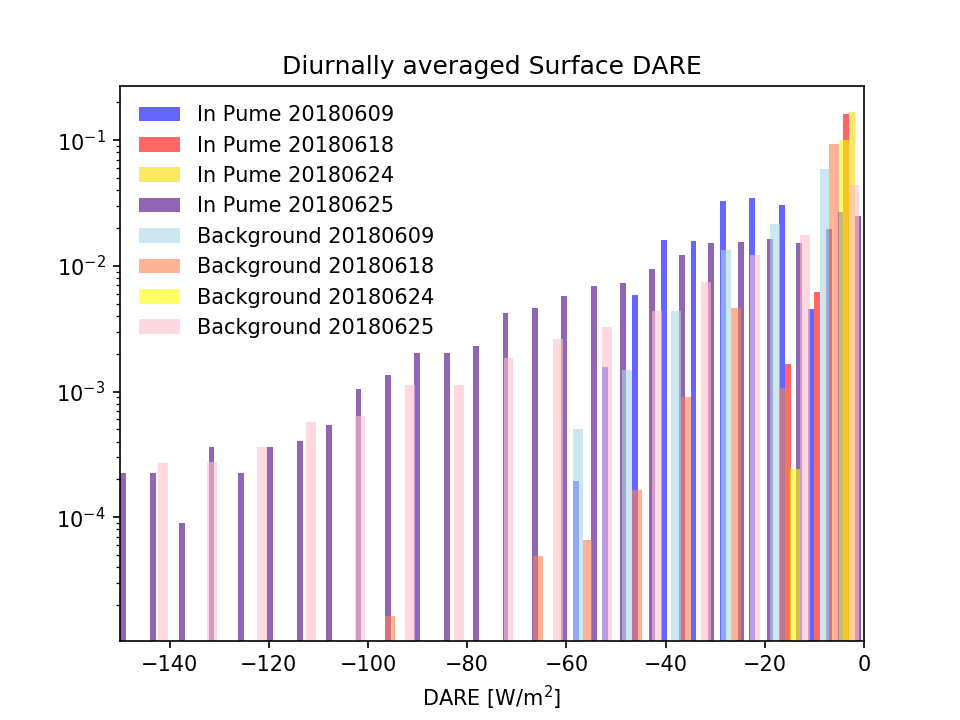

In [414]:
plt.figure()
plt.hist([dare_pl1,dare_pl2,dare_pl3,dare_pl4],color=['b','r','gold','indigo'],
         label=['In Pume 20180609','In Pume 20180618','In Pume 20180624','In Pume 20180625'],normed=True,bins=30,alpha=0.6)
plt.hist([dare_out1,dare_out2,dare_out3,dare_out4],color=['lightblue','coral','yellow','pink'],
         label=['Background 20180609','Background 20180618','Background 20180624','Background 20180625'],
         normed=True,bins=30,alpha=0.6)
plt.xlim(-150,0)
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('DARE [W/m$^2$]')
plt.title('Diurnally averaged Surface DARE')
plt.savefig(fp+'plots/DARE_avg_inplume_out_COSR.png',transparent=True,dpi=600)

<IPython.core.display.Javascript object>


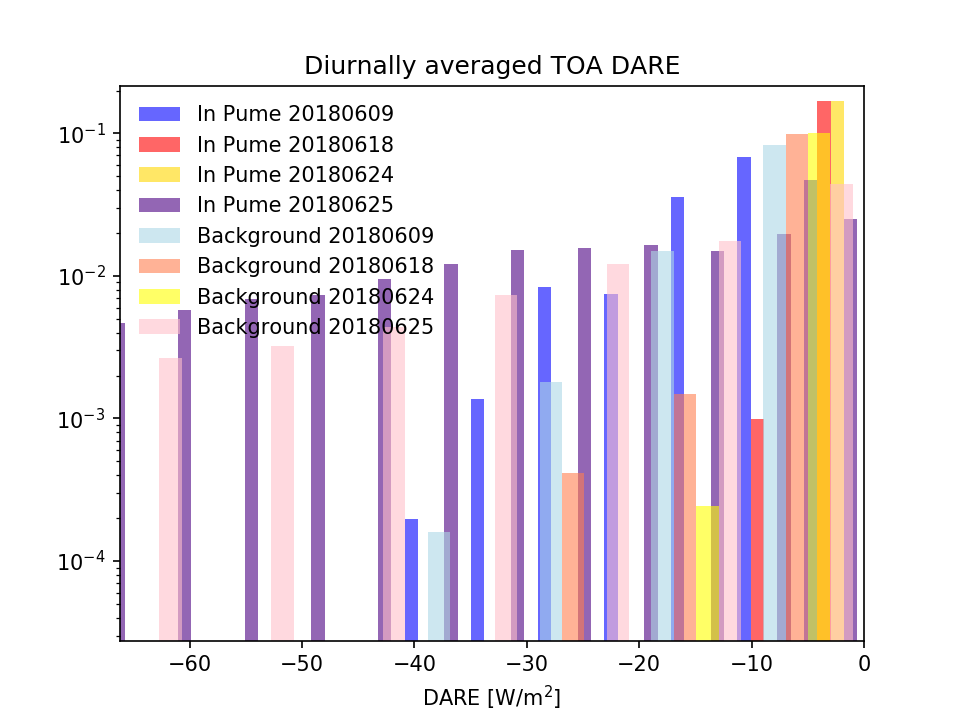

In [421]:
plt.figure()
plt.hist([dare_pl1_toa,dare_pl2_toa,dare_pl3_toa,dare_pl4_toa],color=['b','r','gold','indigo'],
         label=['In Pume 20180609','In Pume 20180618','In Pume 20180624','In Pume 20180625'],normed=True,bins=30,alpha=0.6)
plt.hist([dare_out1_toa,dare_out2_toa,dare_out3_toa,dare_out4_toa],color=['lightblue','coral','yellow','pink'],
         label=['Background 20180609','Background 20180618','Background 20180624','Background 20180625'],
         normed=True,bins=30,alpha=0.6)
plt.xlim(-150,0)
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('DARE [W/m$^2$]')
plt.title('Diurnally averaged TOA DARE')
plt.savefig(fp+'plots/DARE_avg_inplume_out_COSR_TOA.png',transparent=True,dpi=600)

In [406]:
np.nanmean(dare_pl1),np.nanmean(dare_pl2),np.nanmean(dare_pl3),np.nanmean(dare_pl4)

(-21.66743838246268,
 -1.5546438983625734,
 -1.6284513862157686,
 -32.259184600165725)

In [407]:
np.nanmedian(dare_pl1),np.nanmedian(dare_pl2),np.nanmedian(dare_pl3),np.nanmedian(dare_pl4)

(-21.56366102229167,
 -0.8225490857142947,
 -1.6005396770833338,
 -26.777597985645833)

In [408]:
np.nanstd(dare_pl1),np.nanstd(dare_pl2),np.nanstd(dare_pl3),np.nanstd(dare_pl4)

(11.483013744563303,
 2.020551737022134,
 0.25924101865136556,
 26.932736238771025)

In [409]:
np.nanmean(dare_out1),np.nanmean(dare_out2),np.nanmean(dare_out3),np.nanmean(dare_out4)

(-11.223490255448569,
 -3.1603512821298496,
 -2.283641030871713,
 -27.275655916797813)

In [410]:
np.nanmedian(dare_out1),np.nanmedian(dare_out2),np.nanmedian(dare_out3),np.nanmedian(dare_out4)

(-7.7583685166666685,
 -1.2181338857143056,
 -1.7868755625000092,
 -12.762458835416666)

In [411]:
np.nanstd(dare_out1),np.nanstd(dare_out2),np.nanstd(dare_out3),np.nanstd(dare_out4)

(10.474985189042815, 6.760096158681584, 1.3780882852693597, 42.85474214312306)